# Investigation Precipitation and Temperature Time Series
### Updated as of 4/27/2020

* This script investigates the precipitation and temperature data
* Precipitation and temperature data are uploaded to github repository

* This is modelled after Lesson 10 Time Series
* Dr. Silverstein helped to debug the code for cleaning up the data and filling the timedate dataframe. Learned: important to check the data type of the information that is being inputted and outputted of the cell

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

## Precipitation Data

In [2]:
# import data
# source: https://data.gov.in/catalog/rainfall-india?filters%5Bfield_catalog_reference%5D=1090541&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc
import os
os.chdir(r'C:\\Users\\livsh\\Downloads') 
precip = pd.read_csv('monthly precipitation.csv')

**Data Background**
The temperature data is in the form of temperature anomalies (differences from the mean/average value) per month and per season (DJF=Dec-Feb, MAM=Mar-May, etc). We won't be working with absolute temperature data since anomalies are more important than absolute temperature in climate change investigations. A positive anomaly value means that the observed precipitation was greater than the baseline average and a negative anomaly value means that it was less than the baseline average.

In [3]:
raw_precip = precip[(precip['SUBDIVISION']  == 'East Rajasthan')]
len(raw_precip)

117

In [4]:
precip = raw_precip
precip.head()

SUBDIVISION  YEAR   JAN  FEB   MAR  APR   MAY   JUN    JUL    AUG  \
1966  East Rajasthan  1901  21.6  8.9   2.9  0.7   5.0  15.0  164.8  175.6   
1967  East Rajasthan  1902   4.1  0.7   0.0  1.8   9.9  34.6  247.6  116.7   
1968  East Rajasthan  1903   1.9  0.7   1.3  0.1  12.9  15.6  238.2  229.1   
1969  East Rajasthan  1904   4.3  5.5  21.7  0.2  27.5  49.9  289.7  223.5   
1970  East Rajasthan  1905   4.1  8.8   3.2  1.6   2.0  14.4  130.5   30.9   

        SEP   OCT  NOV   DEC  ANNUAL    JF   MAM   JJAS   OND  
1966    7.5   9.8  0.0   0.8   412.5  30.5   8.5  362.9  10.6  
1967  145.6  14.4  0.0   2.8   578.3   4.8  11.7  544.5  17.2  
1968  168.5  17.8  0.0   0.0   686.1   2.7  14.2  651.4  17.8  
1969   50.2   1.5  5.8  14.7   694.5   9.8  49.4  613.3  22.0  
1970   83.8   0.0  0.0   0.6   279.8  12.8   6.8  259.6   0.6

In [5]:
# reset index so it is easier to keep track of years/ index
precip = precip.dropna(axis=0, how = 'any') 
#precip.reset_index(inplace = True)
#instructor code
precip.reset_index(inplace = True, drop = True)


print(len(precip))
precip.head()

117


SUBDIVISION  YEAR   JAN  FEB   MAR  APR   MAY   JUN    JUL    AUG  \
0  East Rajasthan  1901  21.6  8.9   2.9  0.7   5.0  15.0  164.8  175.6   
1  East Rajasthan  1902   4.1  0.7   0.0  1.8   9.9  34.6  247.6  116.7   
2  East Rajasthan  1903   1.9  0.7   1.3  0.1  12.9  15.6  238.2  229.1   
3  East Rajasthan  1904   4.3  5.5  21.7  0.2  27.5  49.9  289.7  223.5   
4  East Rajasthan  1905   4.1  8.8   3.2  1.6   2.0  14.4  130.5   30.9   

     SEP   OCT  NOV   DEC  ANNUAL    JF   MAM   JJAS   OND  
0    7.5   9.8  0.0   0.8   412.5  30.5   8.5  362.9  10.6  
1  145.6  14.4  0.0   2.8   578.3   4.8  11.7  544.5  17.2  
2  168.5  17.8  0.0   0.0   686.1   2.7  14.2  651.4  17.8  
3   50.2   1.5  5.8  14.7   694.5   9.8  49.4  613.3  22.0  
4   83.8   0.0  0.0   0.6   279.8  12.8   6.8  259.6   0.6

In [6]:
precip.isna().sum() 
# all 0's for each column - so no data is missing

SUBDIVISION    0
YEAR           0
JAN            0
FEB            0
MAR            0
APR            0
MAY            0
JUN            0
JUL            0
AUG            0
SEP            0
OCT            0
NOV            0
DEC            0
ANNUAL         0
JF             0
MAM            0
JJAS           0
OND            0
dtype: int64

In [7]:
describe = precip.describe()
describe

YEAR         JAN         FEB         MAR         APR  \
count   117.000000  117.000000  117.000000  117.000000  117.000000   
mean   1959.000000    6.389744    5.328205    4.518803    3.096581   
std      33.919021    8.172530    7.436592    9.067353    5.898582   
min    1901.000000    0.000000    0.000000    0.000000    0.000000   
25%    1930.000000    0.700000    0.400000    0.200000    0.200000   
50%    1959.000000    3.600000    2.200000    1.400000    1.000000   
75%    1988.000000    8.600000    8.500000    4.100000    3.100000   
max    2017.000000   39.200000   35.700000   57.400000   43.200000   

              MAY         JUN         JUL         AUG         SEP         OCT  \
count  117.000000  117.000000  117.000000  117.000000  117.000000  117.000000   
mean     9.862393   63.611111  224.824786  219.015385   97.043590   14.394017   
std     12.160236   42.703270   84.291405   95.187826   70.360389   24.904764   
min      0.000000    5.100000   13.500000   30.900000    3.300000    0.000000   
25%      2.600000   30.800000  164.800000  142.800000   40.400000    0.600000   
50%      5.700000   53.400000  227.800000  223.100000   88.000000    4.700000   
75%     12.700000   89.900000  288.800000  283.700000  131.300000   14.400000   
max     90.900000  209.100000  440.600000  435.800000  337.200000  161.900000   

              NOV         DEC       ANNUAL          JF         MAM  \
count  117.000000  117.000000   117.000000  117.000000  117.000000   
mean     4.794017    3.617949   656.501709   11.715385   17.484615   
std     10.547326    6.700625   166.163458   11.307989   16.819886   
min      0.000000    0.000000   273.600000    0.000000    0.200000   
25%      0.000000    0.100000   551.800000    2.800000    7.800000   
50%      0.400000    0.700000   655.400000    8.800000   12.200000   
75%      3.700000    3.900000   759.900000   17.500000   21.300000   
max     58.100000   37.700000  1350.400000   51.100000  105.900000   

              JJAS         OND  
count   117.000000  117.000000  
mean    604.490598   22.807692  
std     156.559274   27.230530  
min     242.000000    0.000000  
25%     505.700000    4.200000  
50%     611.300000   13.500000  
75%     701.300000   29.900000  
max    1132.000000  168.000000

In [8]:
describe.iloc[[1], [1]]

JAN
mean  6.389744

### DataTime Index
* Create empty dataframe with a DateTime index of monthly frequency and then populate this dataframe using the raw data
* Empty dataframe range from January 1901 to December 2017

In [9]:
# Make a new dataframe with an index for each month
# first create the date range
date_rng = pd.date_range(start='1/1/1901', end='1/1/2018', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# then, create the empty DataFrame, which we will populate using the raw data
p = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the precipitation values
p['Avg_Precip_mm'] = None

# Set the index of the DataFrame to the date column (DateTime index)
p.set_index('date', inplace=True)

# Show the first few elements
p.head()

# using the last day of each month for the indexes bc we only care about the month

Avg_Precip_mm
date                    
1901-01-31          None
1901-02-28          None
1901-03-31          None
1901-04-30          None
1901-05-31          None

### Time series manipulation and dealing with missing values

In [10]:
# select only the data that we want - which is the year column and the month columns, leaving out the season columns
#precip = precip.iloc[:, 2:15]

#instructor code
precip = precip.iloc[:, 1:14]


precip.head()

#instructor code
print(precip.dtypes)
precip['YEAR'] = precip['YEAR'].astype(int)


precip.rename(columns = {'YEAR':'Year', 'JAN':'Jan',
                         'FEB':'Feb', 'MAR':'Mar',
                         'APR':'Apr', 'MAY':'May','JUN':'Jun',
                         'JUL':'Jul', 'AUG':'Aug','SEP':'Sep',
                         'OCT':'Oct', 'NOV':'Nov','DEC':'Dec'}, inplace = True)
print(precip.dtypes)  # want to check the data types
precip.head()

YEAR      int64
JAN     float64
FEB     float64
MAR     float64
APR     float64
MAY     float64
JUN     float64
JUL     float64
AUG     float64
SEP     float64
OCT     float64
NOV     float64
DEC     float64
dtype: object
Year      int32
Jan     float64
Feb     float64
Mar     float64
Apr     float64
May     float64
Jun     float64
Jul     float64
Aug     float64
Sep     float64
Oct     float64
Nov     float64
Dec     float64
dtype: object


Year   Jan  Feb   Mar  Apr   May   Jun    Jul    Aug    Sep   Oct  Nov  \
0  1901  21.6  8.9   2.9  0.7   5.0  15.0  164.8  175.6    7.5   9.8  0.0   
1  1902   4.1  0.7   0.0  1.8   9.9  34.6  247.6  116.7  145.6  14.4  0.0   
2  1903   1.9  0.7   1.3  0.1  12.9  15.6  238.2  229.1  168.5  17.8  0.0   
3  1904   4.3  5.5  21.7  0.2  27.5  49.9  289.7  223.5   50.2   1.5  5.8   
4  1905   4.1  8.8   3.2  1.6   2.0  14.4  130.5   30.9   83.8   0.0  0.0   

    Dec  
0   0.8  
1   2.8  
2   0.0  
3  14.7  
4   0.6

In [11]:
# apply Panda's function to move through the rows of the raw data (axis =0 for columns, 1 for rows)
# also need to important the datetime and calendar libraries that we are going to use


# Import needed libraries
import calendar
from datetime import datetime

# define function 
def pop_df_with_precip_from_row(row):
    year = row['Year'].astype(int) # instructor update
    # anomaly values (appear to be mixture of strings + floats)
    monthly_precip = row.iloc[1:]
    # abbreviated month names (index names)
    months = monthly_precip.index
    for month in monthly_precip.index:
        # get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # populate / set value @ above index, to anomaly value
        p.loc[date_index] = monthly_precip[month]

# apply function to each row of raw data 
_ = precip.apply(lambda row: pop_df_with_precip_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
print(p)

# instructor edits
p['Avg_Precip_mm'] = p['Avg_Precip_mm'].astype(float)
print(p.dtypes)

           Avg_Precip_mm
date                    
1901-01-31          21.6
1901-02-28           8.9
1901-03-31           2.9
1901-04-30           0.7
1901-05-31             5
...                  ...
2017-08-31         137.3
2017-09-30          46.4
2017-10-31             0
2017-11-30           0.4
2017-12-31           3.4

[1404 rows x 1 columns]
Avg_Precip_mm    float64
dtype: object


In [12]:
# no need to clean anonmaly values since there were no NaN

### Plot the time series

C:\Users\livsh\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


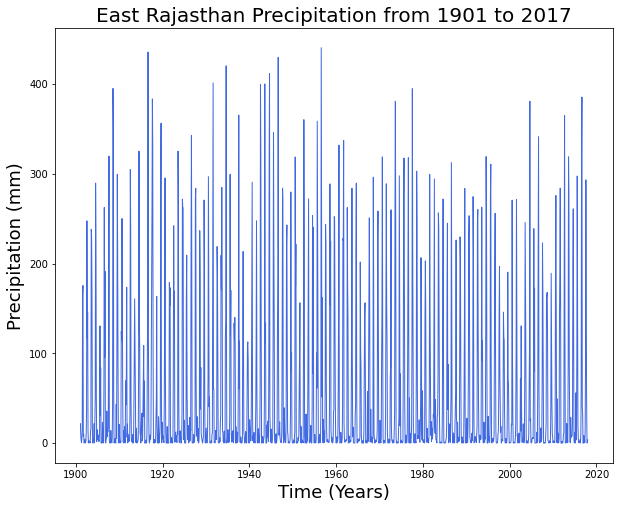

In [13]:
# Plot the data

# import Matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)', fontsize = 18)
plt.ylabel('Precipitation (mm)', fontsize = 18)
plt.title('East Rajasthan Precipitation from 1901 to 2017', fontsize = 20)
plt.plot(p, color='royalblue', linewidth=1.0);

* As we move forward in time, it seems as it the peaks (maximums) are decreasing. This is concurrent with the information from the locals where the project will be
* Above is granualar data. There is a lot of variation and fluctuation and it is difficult to determine the trends from year to year and month to month

### Resampling at a different frequency
* The plot above seems messy in a sense that it covers such a long time span with data that is quite granualar
* The visualization includes a lot of variation
* Change the frequency from months to years

In [14]:
p.resample('A').mean().head()   
# trying to remove fluctuations
# takign the average value (mean)
# A represents the year calendar end

Avg_Precip_mm
date                     
1901-12-31      34.383333
1902-12-31      48.183333
1903-12-31      57.175000
1904-12-31      57.875000
1905-12-31      23.325000

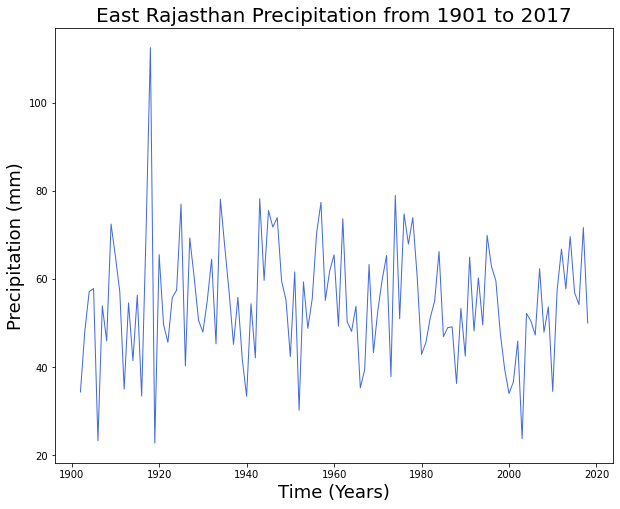

In [15]:
# Visualize the resampled DataFrame

# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)', fontsize = 18)
plt.ylabel('Precipitation (mm)', fontsize = 18)
plt.title('East Rajasthan Precipitation from 1901 to 2017', fontsize = 20)
plt.plot(p.resample('A').mean(), color='royalblue', linewidth=1.0);

* This plot above seems much more clear than the previous graph. The resampling makes it easier to determine and vizualize the precipitation trends

## Temperature Data
* this section will investigate temperature data and create similar visualizations that were created for precipitation data

In [16]:
# import temperature data
# source: https://data.gov.in/resources/monthly-seasonal-and-annual-mean-temp-series-1901-2017
# uploaded temperature data to github

import os
os.chdir(r'C:\\Users\\livsh\\Downloads') 
temp = pd.read_csv('temperature.csv')

In [17]:
temp.head().T

0        1        2        3        4
YEAR    1901.00  1902.00  1903.00  1904.00  1905.00
JAN       17.99    19.00    18.32    17.77    17.40
FEB       19.43    20.39    19.79    19.39    17.79
MAR       23.49    24.10    22.46    22.95    21.78
APR       26.41    26.54    26.03    26.73    24.84
MAY       28.28    28.68    27.93    27.83    28.32
JUN       28.60    28.44    28.41    27.85    28.69
JUL       27.49    27.29    28.04    26.84    27.67
AUG       26.98    27.05    26.63    26.73    27.47
SEP       26.26    25.95    26.34    25.84    26.29
OCT       25.08    24.37    24.57    24.36    26.16
NOV       21.73    21.33    20.96    21.07    22.07
DEC       18.95    18.78    18.29    18.84    18.71
ANNUAL    24.23    24.33    23.80    23.86    23.71
JF        18.71    19.70    19.05    18.66    17.58
MAM       26.06    26.44    25.47    25.84    24.99
JS        27.30    27.18    27.17    26.83    27.37
OND       21.92    21.49    21.27    21.42    21.48

In [18]:
temp = temp.dropna(axis=0, how = 'any') 
temp.reset_index(inplace = True, drop = True)
print(len(temp))  # check length of dataframe
temp.head()

116


YEAR    JAN    FEB    MAR    APR    MAY    JUN    JUL    AUG    SEP    OCT  \
0  1901  17.99  19.43  23.49  26.41  28.28  28.60  27.49  26.98  26.26  25.08   
1  1902  19.00  20.39  24.10  26.54  28.68  28.44  27.29  27.05  25.95  24.37   
2  1903  18.32  19.79  22.46  26.03  27.93  28.41  28.04  26.63  26.34  24.57   
3  1904  17.77  19.39  22.95  26.73  27.83  27.85  26.84  26.73  25.84  24.36   
4  1905  17.40  17.79  21.78  24.84  28.32  28.69  27.67  27.47  26.29  26.16   

     NOV    DEC  ANNUAL     JF    MAM     JS    OND  
0  21.73  18.95   24.23  18.71  26.06  27.30  21.92  
1  21.33  18.78   24.33  19.70  26.44  27.18  21.49  
2  20.96  18.29   23.80  19.05  25.47  27.17  21.27  
3  21.07  18.84   23.86  18.66  25.84  26.83  21.42  
4  22.07  18.71   23.71  17.58  24.99  27.37  21.48

In [19]:
temp.isna().sum() 
# all 0's for each column - so no data is missing

YEAR      0
JAN       0
FEB       0
MAR       0
APR       0
MAY       0
JUN       0
JUL       0
AUG       0
SEP       0
OCT       0
NOV       0
DEC       0
ANNUAL    0
JF        0
MAM       0
JS        0
OND       0
dtype: int64

In [20]:
describe = temp.describe().T
describe

count         mean        std      min        25%       50%  \
YEAR    116.0  1958.500000  33.630343  1901.00  1929.7500  1958.500   
JAN     116.0    18.404569   0.581218    17.25    18.0675    18.340   
FEB     116.0    20.112586   0.861884    17.79    19.4700    19.985   
MAR     116.0    23.415690   0.842945    21.78    22.8325    23.320   
APR     116.0    26.491207   0.711790    24.84    25.9900    26.535   
MAY     116.0    28.368448   0.617371    26.97    27.9475    28.335   
JUN     116.0    28.291121   0.450134    27.33    28.0175    28.250   
JUL     116.0    27.361121   0.336064    26.48    27.1500    27.340   
AUG     116.0    26.929914   0.332510    26.21    26.7275    26.895   
SEP     116.0    26.327414   0.352551    25.47    26.1075    26.310   
OCT     116.0    24.720517   0.514948    23.52    24.3850    24.665   
NOV     116.0    21.747155   0.604138    20.59    21.3175    21.715   
DEC     116.0    19.153534   0.601364    17.98    18.7750    19.165   
ANNUAL  116.0    24.261379   0.396366    23.56    24.0000    24.150   
JF      116.0    19.236810   0.630786    17.58    18.8450    19.115   
MAM     116.0    26.067328   0.572031    24.89    25.6775    26.030   
JS      116.0    27.222414   0.294390    26.53    27.0600    27.180   
OND     116.0    21.860086   0.507280    20.96    21.4800    21.815   

              75%      max  
YEAR    1987.2500  2016.00  
JAN       18.7200    20.92  
FEB       20.5425    23.58  
MAR       23.9150    26.61  
APR       26.9025    29.56  
MAY       28.7525    30.78  
JUN       28.5650    29.88  
JUL       27.5150    28.47  
AUG       27.1425    28.17  
SEP       26.4850    27.72  
OCT       24.9200    26.81  
NOV       22.1425    23.90  
DEC       19.5350    21.89  
ANNUAL    24.4525    26.45  
JF        19.5875    22.25  
MAM       26.4125    28.86  
JS        27.3400    28.44  
OND       22.1400    24.20

In [21]:
# Make a new dataframe with an index for each month
# first create the date range
date_rng = pd.date_range(start='1/1/1901', end='12/31/2017', freq='M')

type(date_rng[0])
# returns 
# pandas._libs.tslibs.timestamps.Timestamp

# Empty DataFrame and populate with the raw data
t = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
t['Avg_Temp_deg_C'] = None

# Set the index of the dataframe to the date column (datetime index)
t.set_index('date', inplace=True)

# Show the first few elements
t.head()

# using the last day of each month for the indexes bc we only care about the month

Avg_Temp_deg_C
date                     
1901-01-31           None
1901-02-28           None
1901-03-31           None
1901-04-30           None
1901-05-31           None

In [22]:
len(t)

1404

In [23]:
# select only the data that we want - which is the year column and the month columns, leaving out the season columns
#precip = precip.iloc[:, 2:15]

#instructor code
temp = temp.iloc[:, :13]


temp.head()

#instructor code
print(temp.dtypes)
temp['YEAR'] = temp['YEAR'].astype(int)


temp.rename(columns = {'YEAR':'Year', 'JAN':'Jan',
                         'FEB':'Feb', 'MAR':'Mar',
                         'APR':'Apr', 'MAY':'May','JUN':'Jun',
                         'JUL':'Jul', 'AUG':'Aug','SEP':'Sep',
                         'OCT':'Oct', 'NOV':'Nov','DEC':'Dec'}, inplace = True)
print(temp.dtypes)
temp.head()

YEAR      int64
JAN     float64
FEB     float64
MAR     float64
APR     float64
MAY     float64
JUN     float64
JUL     float64
AUG     float64
SEP     float64
OCT     float64
NOV     float64
DEC     float64
dtype: object
Year      int32
Jan     float64
Feb     float64
Mar     float64
Apr     float64
May     float64
Jun     float64
Jul     float64
Aug     float64
Sep     float64
Oct     float64
Nov     float64
Dec     float64
dtype: object


Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
0  1901  17.99  19.43  23.49  26.41  28.28  28.60  27.49  26.98  26.26  25.08   
1  1902  19.00  20.39  24.10  26.54  28.68  28.44  27.29  27.05  25.95  24.37   
2  1903  18.32  19.79  22.46  26.03  27.93  28.41  28.04  26.63  26.34  24.57   
3  1904  17.77  19.39  22.95  26.73  27.83  27.85  26.84  26.73  25.84  24.36   
4  1905  17.40  17.79  21.78  24.84  28.32  28.69  27.67  27.47  26.29  26.16   

     Nov    Dec  
0  21.73  18.95  
1  21.33  18.78  
2  20.96  18.29  
3  21.07  18.84  
4  22.07  18.71

In [24]:
# Import needed libraries
import calendar
from datetime import datetime

# define function 
def pop_df_with_temp_from_row(row):
    year = row['Year'].astype(int)
    # anomaly values (appear to be mixture of strings + floats)
    monthly_temp = row.iloc[1:]
    # abbreviated month names (index names)
    months = monthly_temp.index
    for month in monthly_temp.index:
        # get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # populate / set value @ above index, to anomaly value
        t.loc[date_index] = monthly_temp[month]

# apply function to each row of raw data 
_ = temp.apply(lambda row: pop_df_with_temp_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
print(t)

t['Avg_Temp_deg_C'] = t['Avg_Temp_deg_C'].astype(float)
print(t.dtypes)

           Avg_Temp_deg_C
date                     
1901-01-31          17.99
1901-02-28          19.43
1901-03-31          23.49
1901-04-30          26.41
1901-05-31          28.28
...                   ...
2017-08-31           None
2017-09-30           None
2017-10-31           None
2017-11-30           None
2017-12-31           None

[1404 rows x 1 columns]
Avg_Temp_deg_C    float64
dtype: object


#### Plot the data

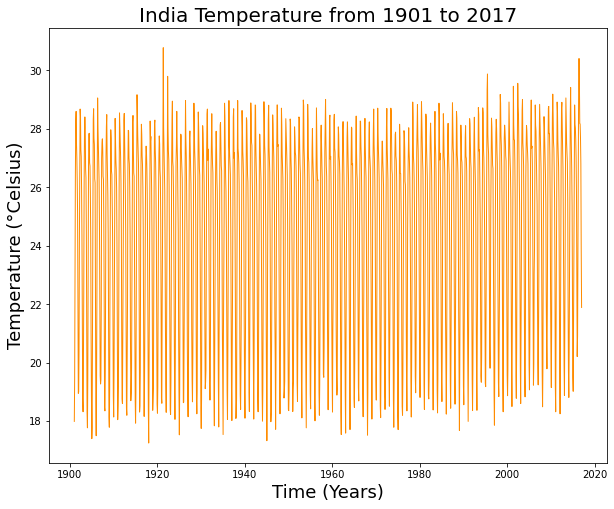

In [25]:
# create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)', fontsize = 18)
plt.ylabel('Temperature (°Celsius)', fontsize = 18)
plt.title('India Temperature from 1901 to 2017', fontsize = 20)
plt.plot(t, color='darkorange', linewidth=1.0);

* This graph is very granular and difficult to determine the trends from year to year
* would be helpful to resample at annual frequency instead

### Resampling at a different frequency

In [26]:
t.resample('A').mean().head()   
# trying to remove fluctuations
# takign the average value (mean)
# A represents the year calendar end

Avg_Temp_deg_C
date                      
1901-12-31       24.224167
1902-12-31       24.326667
1903-12-31       23.980833
1904-12-31       23.850000
1905-12-31       23.932500

In [27]:
t.resample('A').mean()

Avg_Temp_deg_C
date                      
1901-12-31       24.224167
1902-12-31       24.326667
1903-12-31       23.980833
1904-12-31       23.850000
1905-12-31       23.932500
...                    ...
2013-12-31       24.820000
2014-12-31       24.732500
2015-12-31       24.912500
2016-12-31       26.454167
2017-12-31             NaN

[117 rows x 1 columns]

In [28]:
print(t.dtypes)  # want to check the data types

Avg_Temp_deg_C    float64
dtype: object


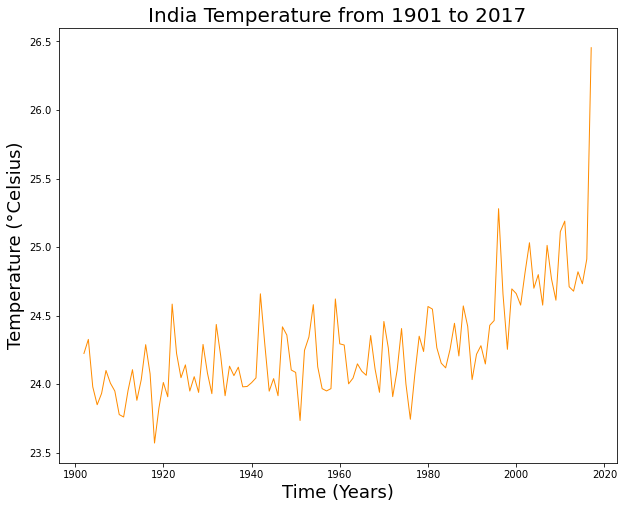

In [29]:
# Visualize our resampled DataFrame

# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)', fontsize = 18)
plt.ylabel('Temperature (°Celsius)', fontsize = 18)
plt.title('India Temperature from 1901 to 2017', fontsize = 20)
plt.plot(t.resample('A').mean(), color='darkorange', linewidth=1.0);

## Viszualizing
* since the datasets have been formated, can now plot them 
* will used two libraries to plot the data: Matplotlib and Plotly


### Plotting with Matplotlib

**Precipitation**

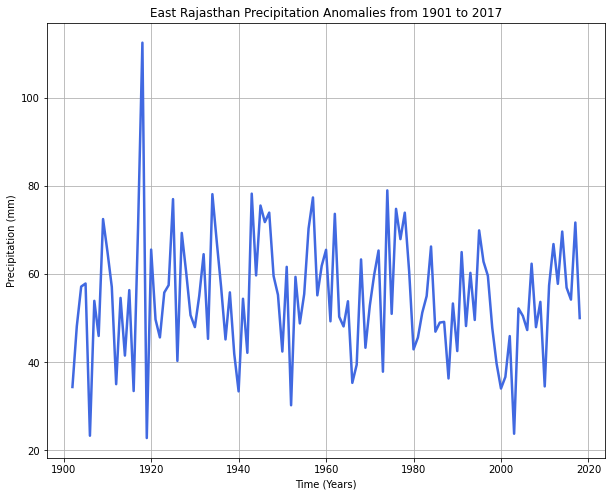

In [30]:
# Resample for precipitation data to years (end-of-year)

p_resampled = p.resample('A').mean()

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot precipiation data with specific color and line thickness
ax.plot(p_resampled, color='royalblue', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (Years)', ylabel='Precipitation (mm)',
       title='East Rajasthan Precipitation Anomalies from 1901 to 2017')

# Enable grid
ax.grid();

**Temperature**

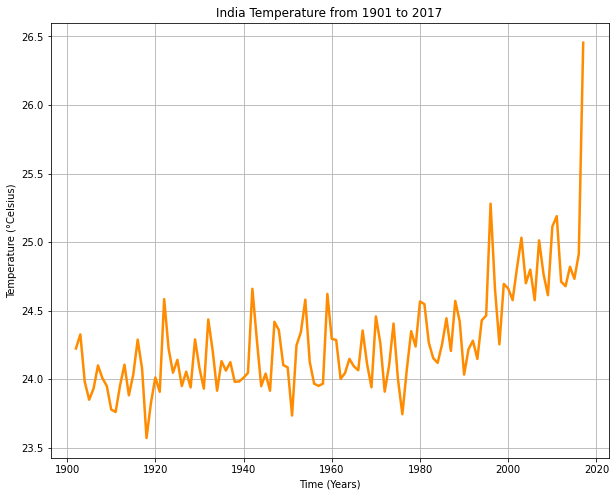

In [31]:
# Resample for temperature data to years (end-of-year)
t_resampled = t.resample('A').mean()

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot temperature data with specific color and line thickness
ax.plot(t_resampled, color='darkorange', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (Years)', ylabel='Temperature (°Celsius)',
       title='India Temperature from 1901 to 2017')

# set grid
ax.grid();

### Plotting with Plotly
* more visualization of the precipitation and temperature anomalies

In [32]:
# install plotly https://anaconda.org/plotly/plotly
# Standard plotly imports
import plotly.graph_objects as go
from plotly.offline import plot, iplot

In [33]:
# using plotly and cufflinks for create more visualizations --> no importing for cufflinks
# trace for line plot of temp anomalies

trace1 = go.Scatter(
                    x = t_resampled.index,
                    y = t_resampled.Avg_Temp_deg_C,
                    mode = "lines",
                    marker = dict(color = 'darkorange'))

data = [trace1]
layout = dict(title = 'India Temperature from 1901 to 2017',
              xaxis= dict(title= 'Time (Years)',ticklen= 5,zeroline= False),
              yaxis=dict(title = 'Temperature (°Celsius)')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

# have temp anomoly and the month and year

In [34]:
# trace for line plot of precipitation
trace2 = go.Scatter(
                    x = p_resampled.index,
                    y = p_resampled.Avg_Precip_mm,
                    mode = "lines",
                    marker = dict(color = 'darkblue'))

data = [trace2]
layout = dict(title = 'East Rajasthan Precipitation from 1901 to 2017',
              xaxis= dict(title= 'Time (Years)',ticklen= 5,zeroline= False),
              yaxis=dict(title = 'Precipitation (mm)')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

* These plots are eas to interact with and investigate the anomalies for temperature and precipitation
* from the temperature graph, one can observe a pretty clear upward trend for temperature
* from the precipitation graph, there appears to be a downward trend for the amount of precipitation. This is consistent with the information from locals near the project

***
# Time Series Correlation
## Forcasting using Facebook's Prophet
### Creating, fitting, and plotting a model for precipitation

In [35]:
# conda install -c conda-forge fbprophet

**Precipitation prediction with months**

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


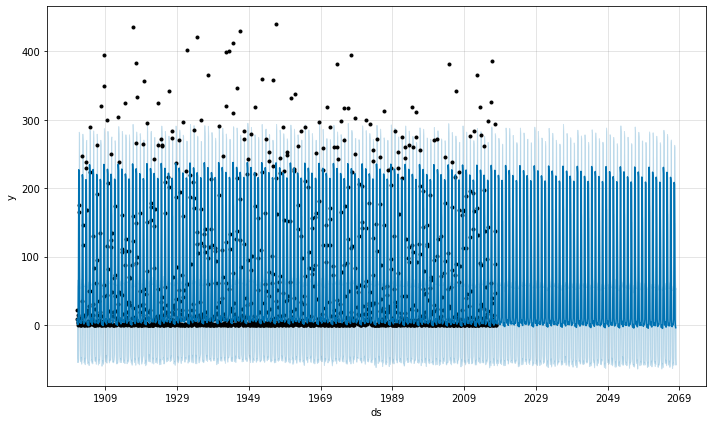

In [36]:
# import Facebook's Prophet forecasting library
from fbprophet import Prophet

# create a new DataFrame --> create/train our Prophet model 
p_prophet = pd.DataFrame()
p_prophet['ds'] = p.index
p_prophet['y'] = p['Avg_Precip_mm'].values

# instantiate model and fit to data (like sklearn model API)
m = Prophet()
m.fit(p_prophet)

# Future dataframe containing predictions - this is for the next 50 years
future = m.make_future_dataframe(freq='m', periods=50*12)
forecast = m.predict(future)

# plot the resulting forecast
m.plot(forecast);

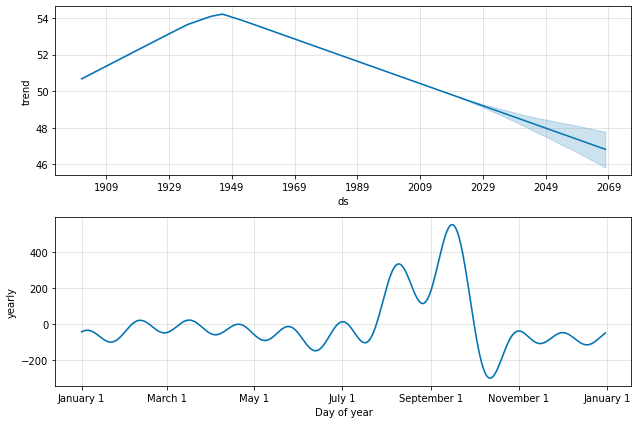

In [37]:
# Plot the forecast components
m.plot_components(forecast);

* The trend and yearly seasonality of the time series are graphed above
* There is a trend for decreasing precipitation as time goes on and for the 50 year precipitation prediction model
* For the seaonality, the cyclical nature of precipiation patterns throughout the year in India is expected. Monsoon season is typically in JJAS (June, Jule, August, and September). It is suprising that the local maximums of this plot are so great in Septemeber and into October.

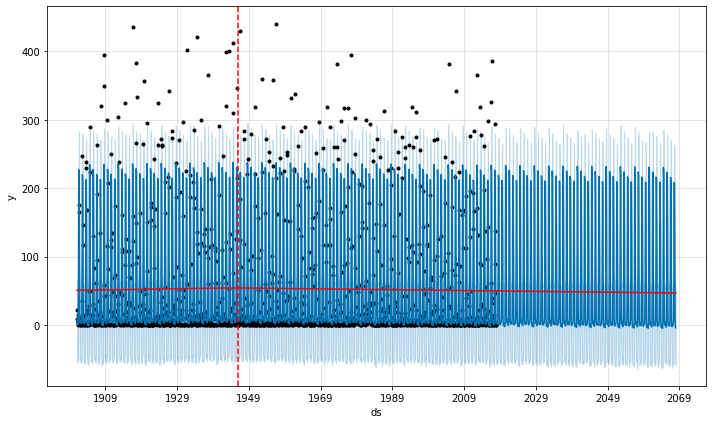

In [38]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

* Looks like a similar pattern and value of precipitation wil occur for the next 50 (thirty) years based on this model

In [39]:
# Dates where the changepoints occurred
m.changepoints

45     1904-10-31
90     1908-07-31
135    1912-04-30
180    1916-01-31
224    1919-09-30
269    1923-06-30
314    1927-03-31
359    1930-12-31
404    1934-09-30
449    1938-06-30
494    1942-03-31
539    1945-12-31
583    1949-08-31
628    1953-05-31
673    1957-02-28
718    1960-11-30
763    1964-08-31
808    1968-05-31
853    1972-02-29
898    1975-11-30
942    1979-07-31
987    1983-04-30
1032   1987-01-31
1077   1990-10-31
1122   1994-07-31
Name: ds, dtype: datetime64[ns]

In [40]:
# investigate the future dataframe
forecast.head(12)

# source: https://facebook.github.io/prophet/docs/quick_start.html
# yhat is the predicted value, there are columns for components and uncertainty intervals

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  1901-01-31  50.675494  -47.915356   66.217658    50.675494    50.675494   
1  1901-02-28  50.682273  -54.010896   57.781585    50.682273    50.682273   
2  1901-03-31  50.689779  -53.076015   58.831441    50.689779    50.689779   
3  1901-04-30  50.697043  -54.116183   56.564746    50.697043    50.697043   
4  1901-05-31  50.704549  -49.197412   66.513572    50.704549    50.704549   
5  1901-06-30  50.711813    5.846055  121.963293    50.711813    50.711813   
6  1901-07-31  50.719319  170.820676  282.544266    50.719319    50.719319   
7  1901-08-31  50.726826  163.921774  280.615795    50.726826    50.726826   
8  1901-09-30  50.734089   33.064520  148.341908    50.734089    50.734089   
9  1901-10-31  50.741596  -36.184096   71.514514    50.741596    50.741596   
10 1901-11-30  50.748859  -52.924778   58.162388    50.748859    50.748859   
11 1901-12-31  50.756366  -51.495084   54.572857    50.756366    50.756366   

    additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0       -42.385732            -42.385732            -42.385732  -42.385732   
1       -46.909890            -46.909890            -46.909890  -46.909890   
2       -48.324967            -48.324967            -48.324967  -48.324967   
3       -50.106083            -50.106083            -50.106083  -50.106083   
4       -43.496394            -43.496394            -43.496394  -43.496394   
5        11.864924             11.864924             11.864924   11.864924   
6       176.234364            176.234364            176.234364  176.234364   
7       169.252942            169.252942            169.252942  169.252942   
8        38.480915             38.480915             38.480915   38.480915   
9       -37.497223            -37.497223            -37.497223  -37.497223   
10      -47.192325            -47.192325            -47.192325  -47.192325   
11      -47.893391            -47.893391            -47.893391  -47.893391   

    yearly_lower  yearly_upper  multiplicative_terms  \
0     -42.385732    -42.385732                   0.0   
1     -46.909890    -46.909890                   0.0   
2     -48.324967    -48.324967                   0.0   
3     -50.106083    -50.106083                   0.0   
4     -43.496394    -43.496394                   0.0   
5      11.864924     11.864924                   0.0   
6     176.234364    176.234364                   0.0   
7     169.252942    169.252942                   0.0   
8      38.480915     38.480915                   0.0   
9     -37.497223    -37.497223                   0.0   
10    -47.192325    -47.192325                   0.0   
11    -47.893391    -47.893391                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                          0.0                         0.0    8.289761  
1                          0.0                         0.0    3.772383  
2                          0.0                         0.0    2.364813  
3                          0.0                         0.0    0.590960  
4                          0.0                         0.0    7.208155  
5                          0.0                         0.0   62.576738  
6                          0.0                         0.0  226.953684  
7                          0.0                         0.0  219.979768  
8                          0.0                         0.0   89.215005  
9                          0.0                         0.0   13.244372  
10                         0.0                         0.0    3.556535  
11                         0.0                         0.0    2.862975

In [41]:
forecast.to_csv('fbprophet_avg_precip_per_month.csv')

**Multivariate Analysis**

In [42]:
# Make a new dataframe with an index for each year
p_new = p.resample('Y').mean()
p_new = p_new['1901-01-01':'2018-01-01']
p_new.head()

Avg_Precip_mm
date                     
1901-12-31      34.383333
1902-12-31      48.183333
1903-12-31      57.175000
1904-12-31      57.875000
1905-12-31      23.325000

In [43]:
len(p_new) # check length of new dataframe --> should be 117 since data is from 1901 to 2017

117

In [44]:
# add more data

fitting = pd.DataFrame()  # define new dataframe

fitting['ds'] = p_new.index
fitting.head()
len(fitting)

117

In [45]:
fitting['y'] = p_new['Avg_Precip_mm'].values
fitting['y']

0      34.383333
1      48.183333
2      57.175000
3      57.875000
4      23.325000
         ...    
112    69.666667
113    56.941667
114    54.225000
115    71.716667
116    50.033333
Name: y, Length: 117, dtype: float64

In [46]:
fitting['t'] = t.resample('A').mean()['Avg_Temp_deg_C'].values
# fill in NaN values - forward fill to fill in the missing values of the dataframe
fitting['t'].fillna(method='ffill', inplace=True)
fitting['t']

0      24.224167
1      24.326667
2      23.980833
3      23.850000
4      23.932500
         ...    
112    24.820000
113    24.732500
114    24.912500
115    26.454167
116    26.454167
Name: t, Length: 117, dtype: float64

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


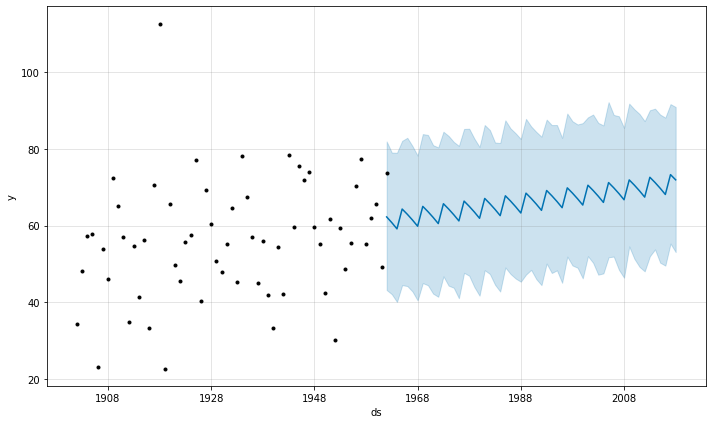

In [47]:
training_X = fitting.loc[:60]
training_y = fitting.loc[:60].drop(['ds','t'], axis=1)
testing_X = fitting.loc[60:]
testing_y = fitting.loc[60:].drop(['ds','t'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [48]:
forecast_data.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1961-12-31 -35.227220   43.236998   81.891875   -35.227220   -35.227220   
1 1962-12-31 -35.195498   42.146875   78.991339   -35.195498   -35.195498   
2 1963-12-31 -35.163777   40.137830   78.946588   -35.163777   -35.163777   
3 1964-12-31 -35.131968   44.509275   82.048960   -35.131968   -35.131968   
4 1965-12-31 -35.100246   44.267915   82.838787   -35.100246   -35.100246   

   additive_terms  additive_terms_lower  additive_terms_upper  \
0       97.484422             97.484422             97.484422   
1       95.960535             95.960535             95.960535   
2       94.310842             94.310842             94.310842   
3       99.442164             99.442164             99.442164   
4       98.045984             98.045984             98.045984   

   extra_regressors_additive  ...           t     t_lower     t_upper  \
0                -194.520165  ... -194.520165 -194.520165 -194.520165   
1                -194.379871  ... -194.379871 -194.379871 -194.379871   
2                -194.239576  ... -194.239576 -194.239576 -194.239576   
3                -194.098897  ... -194.098897 -194.098897 -194.098897   
4                -193.958603  ... -193.958603 -193.958603 -193.958603   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  292.004587    292.004587    292.004587                   0.0   
1  290.340405    290.340405    290.340405                   0.0   
2  288.550418    288.550418    288.550418                   0.0   
3  293.541061    293.541061    293.541061                   0.0   
4  292.004587    292.004587    292.004587                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  62.257201  
1                         0.0                         0.0  60.765036  
2                         0.0                         0.0  59.147065  
3                         0.0                         0.0  64.310196  
4                         0.0                         0.0  62.945738  

[5 rows x 22 columns]

In [49]:
# save dataframe as csv
forecast_data.to_csv('fbprophet_multivar_avg_precip_per_month.csv')

***

# ANNUAL PRECIPITATION

In [50]:
# Make a new dataframe with an index for each month
# first create the date range
date_rng = pd.date_range(start='1/1/1901', end='1/1/2018', freq='A')

type(date_rng[0])

# Create empty DataFrame --> populate using the raw data
p = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the precipitation values
p['Annual_Precip_mm'] = None

# Set the index of the DataFrame to the date column (DateTime index)
p.set_index('date', inplace=True)

# Show the first few elements
p.head()

# using the last day of each month for the indexes bc we only care about the month

Annual_Precip_mm
date                       
1901-12-31             None
1902-12-31             None
1903-12-31             None
1904-12-31             None
1905-12-31             None

In [51]:
annual_precip = pd.DataFrame()
annual_precip = raw_precip[['YEAR', 'ANNUAL']]

# reset index so it is easier to keep track of years/ index
annual_precip = annual_precip.dropna(axis=0, how = 'any') 
#precip.reset_index(inplace = True)
#instructor code
annual_precip.reset_index(inplace = True, drop = True)

# print annual precipitation dataframe and check length
print(len(annual_precip))
annual_precip.head()

117


YEAR  ANNUAL
0  1901   412.5
1  1902   578.3
2  1903   686.1
3  1904   694.5
4  1905   279.8

In [52]:
annual_precip.isna().sum() 
# all 0's for each column - so no data is missing

YEAR      0
ANNUAL    0
dtype: int64

In [53]:
print(annual_precip.dtypes)
annual_precip['YEAR'] = annual_precip['YEAR'].astype(int)


annual_precip.rename(columns = {'YEAR':'Year', 'ANNUAL':'Annual'}, inplace = True)
print(annual_precip.dtypes)  # want to check the data types
annual_precip.head()

YEAR        int64
ANNUAL    float64
dtype: object
Year        int32
Annual    float64
dtype: object


Year  Annual
0  1901   412.5
1  1902   578.3
2  1903   686.1
3  1904   694.5
4  1905   279.8

In [54]:
# investigating how datetime works
# not part of model
'''
import datetime
x = datetime.date(2012, 5, 1)
print(x)

type(x)
'''

'\nimport datetime\nx = datetime.date(2012, 5, 1)\nprint(x)\n\ntype(x)\n'

In [55]:
# investigating how datetimes works
# not part of model
'''
for year in range(1901, 2018):
    x = datetime.date(year, 12, 31)
    print(x)
'''

'\nfor year in range(1901, 2018):\n    x = datetime.date(year, 12, 31)\n    print(x)\n'

In [56]:
# Change year from int to datetime datatype
# instructor help

from datetime import datetime
my_string = '-12-31'
annual_precip['Year'] = annual_precip['Year'].astype(str)+my_string
annual_precip.head()
#annual_precip['new_year1']

for row in range(0,len(annual_precip)):
    annual_precip['Year'][row]= datetime.strptime(annual_precip['Year'][row],"%Y-%m-%d")
annual_precip.head()

C:\Users\livsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Year  Annual
0  1901-12-31 00:00:00   412.5
1  1902-12-31 00:00:00   578.3
2  1903-12-31 00:00:00   686.1
3  1904-12-31 00:00:00   694.5
4  1905-12-31 00:00:00   279.8

In [57]:
print(annual_precip.dtypes)  # want to check the data types

Year       object
Annual    float64
dtype: object


In [58]:
# Remove time from year (keep year-12-31)
# source: https://stackoverflow.com/questions/26153795/python-remove-time-from-datetime-string

for row in range(0,len(annual_precip)):
    annual_precip['Year'][row]= annual_precip['Year'][row].date()
annual_precip.head()

C:\Users\livsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Year  Annual
0  1901-12-31   412.5
1  1902-12-31   578.3
2  1903-12-31   686.1
3  1904-12-31   694.5
4  1905-12-31   279.8

In [59]:
print(annual_precip.dtypes)  # want to check the data types

Year       object
Annual    float64
dtype: object


In [60]:
type(annual_precip['Year'].iloc[1]) # want to check the data types

datetime.date

### Facebook Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


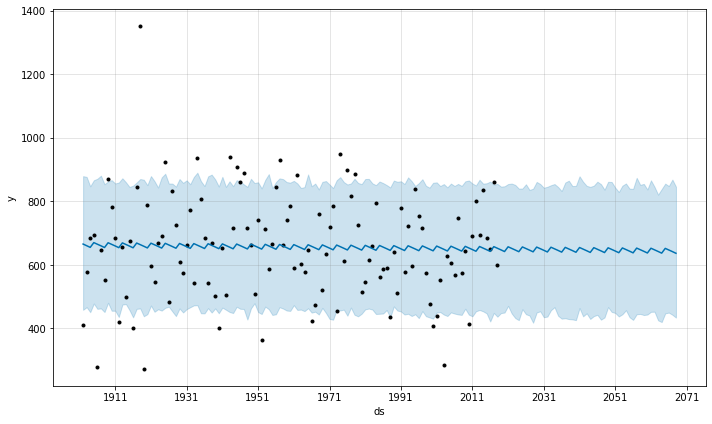

In [61]:
# create a new DataFrame --> create/train our Prophet model 
p_prophet = pd.DataFrame()
p_prophet['ds'] = annual_precip['Year']
p_prophet['y'] = annual_precip['Annual'].values

# instantiate model and fit to data (like sklearn model API)
m = Prophet()
m.fit(p_prophet)

# Future dataframe containing predictions - this is for the next 50 years
future = m.make_future_dataframe(freq='a', periods=50)
forecast = m.predict(future)

# plot the resulting forecast
m.plot(forecast);

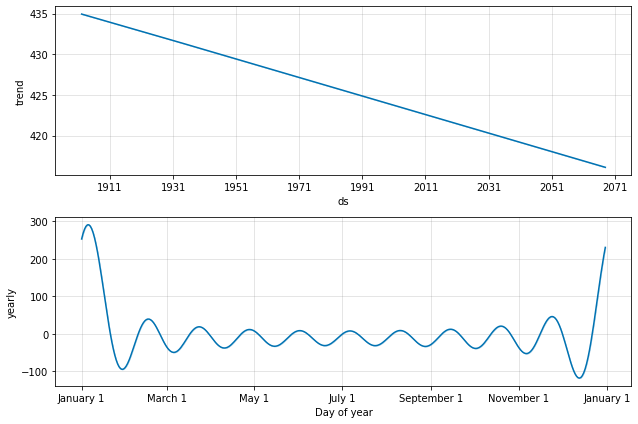

In [62]:
# Plot the forecast components
m.plot_components(forecast);

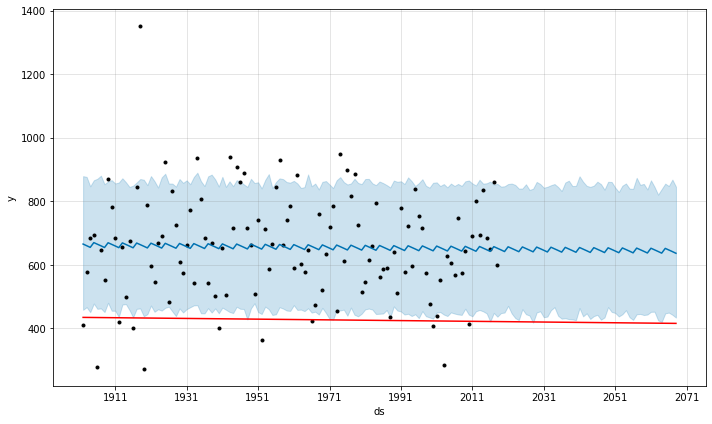

In [63]:
# add change points

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [64]:
# Dates where the changepoints occurred
m.changepoints

4    1905-12-31
7    1908-12-31
11   1912-12-31
15   1916-12-31
18   1919-12-31
22   1923-12-31
26   1927-12-31
29   1930-12-31
33   1934-12-31
37   1938-12-31
40   1941-12-31
44   1945-12-31
48   1949-12-31
52   1953-12-31
55   1956-12-31
59   1960-12-31
63   1964-12-31
66   1967-12-31
70   1971-12-31
74   1975-12-31
77   1978-12-31
81   1982-12-31
85   1986-12-31
88   1989-12-31
92   1993-12-31
Name: ds, dtype: datetime64[ns]

In [65]:
# investigate the future dataframe
forecast.head(12)

# source: https://facebook.github.io/prophet/docs/quick_start.html
# yhat is the predicted value, there are columns for components and uncertainty intervals

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  1901-12-31  434.944641  458.697045  879.320029   434.944641   434.944641   
1  1902-12-31  434.833012  467.085080  876.797962   434.833012   434.833012   
2  1903-12-31  434.721384  451.246143  847.210379   434.721384   434.721384   
3  1904-12-31  434.609450  478.471856  866.282262   434.609450   434.609450   
4  1905-12-31  434.497821  461.858806  871.120808   434.497821   434.497821   
5  1906-12-31  434.386193  463.121285  880.687543   434.386193   434.386193   
6  1907-12-31  434.274564  451.760929  853.761571   434.274564   434.274564   
7  1908-12-31  434.162630  480.984965  862.552146   434.162630   434.162630   
8  1909-12-31  434.051002  455.790406  866.664067   434.051002   434.051002   
9  1910-12-31  433.939373  455.837257  856.264267   433.939373   433.939373   
10 1911-12-31  433.827745  436.173863  859.100345   433.827745   433.827745   
11 1912-12-31  433.715811  475.232559  872.584581   433.715811   433.715811   

    additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0       230.692705            230.692705            230.692705  230.692705   
1       225.668978            225.668978            225.668978  225.668978   
2       220.486633            220.486633            220.486633  220.486633   
3       235.551702            235.551702            235.551702  235.551702   
4       230.692705            230.692705            230.692705  230.692705   
5       225.668978            225.668978            225.668978  225.668978   
6       220.486633            220.486633            220.486633  220.486633   
7       235.551702            235.551702            235.551702  235.551702   
8       230.692705            230.692705            230.692705  230.692705   
9       225.668978            225.668978            225.668978  225.668978   
10      220.486633            220.486633            220.486633  220.486633   
11      235.551702            235.551702            235.551702  235.551702   

    yearly_lower  yearly_upper  multiplicative_terms  \
0     230.692705    230.692705                   0.0   
1     225.668978    225.668978                   0.0   
2     220.486633    220.486633                   0.0   
3     235.551702    235.551702                   0.0   
4     230.692705    230.692705                   0.0   
5     225.668978    225.668978                   0.0   
6     220.486633    220.486633                   0.0   
7     235.551702    235.551702                   0.0   
8     230.692705    230.692705                   0.0   
9     225.668978    225.668978                   0.0   
10    220.486633    220.486633                   0.0   
11    235.551702    235.551702                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                          0.0                         0.0  665.637346  
1                          0.0                         0.0  660.501990  
2                          0.0                         0.0  655.208017  
3                          0.0                         0.0  670.161152  
4                          0.0                         0.0  665.190526  
5                          0.0                         0.0  660.055171  
6                          0.0                         0.0  654.761197  
7                          0.0                         0.0  669.714332  
8                          0.0                         0.0  664.743707  
9                          0.0                         0.0  659.608351  
10                         0.0                         0.0  654.314378  
11                         0.0                         0.0  669.267513

In [66]:
forecast.to_csv("fbprophet_annual_precip.csv")

### Multivariate Analysis

In [67]:
# add more data

fitting = pd.DataFrame()  # define new dataframe

fitting['ds'] = p_new.index
display(fitting.head())
len(fitting)

ds
0 1901-12-31
1 1902-12-31
2 1903-12-31
3 1904-12-31
4 1905-12-31

117

In [68]:
fitting['y'] = annual_precip['Annual'].values
fitting['y']

0      412.5
1      578.3
2      686.1
3      694.5
4      279.8
       ...  
112    836.1
113    683.3
114    650.7
115    860.6
116    600.3
Name: y, Length: 117, dtype: float64

In [69]:
fitting['t'] = t.resample('A').mean()['Avg_Temp_deg_C'].values
# fill in NaN values - forward fill to fill in the missing values of the dataframe
fitting['t'].fillna(method='ffill', inplace=True)
fitting['t']

0      24.224167
1      24.326667
2      23.980833
3      23.850000
4      23.932500
         ...    
112    24.820000
113    24.732500
114    24.912500
115    26.454167
116    26.454167
Name: t, Length: 117, dtype: float64

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


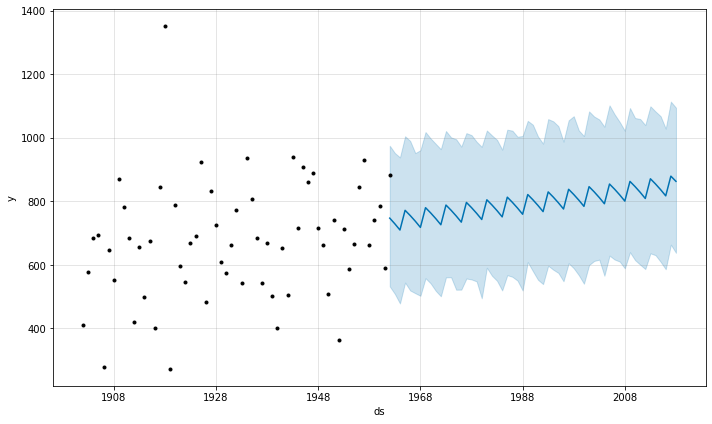

In [70]:
# 50% train, 50% test

training_X = fitting.loc[:60]
training_y = fitting.loc[:60].drop(['ds','t'], axis=1)
testing_X = fitting.loc[60:]
testing_y = fitting.loc[60:].drop(['ds','t'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [71]:
forecast_data.head(57)

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  1961-12-31 -422.294812  532.403431   974.914937  -422.294812  -422.294812   
1  1962-12-31 -421.915676  508.831641   952.080628  -421.915676  -421.915676   
2  1963-12-31 -421.536540  478.735570   938.202212  -421.536540  -421.536540   
3  1964-12-31 -421.156365  544.376376  1004.684322  -421.156365  -421.156365   
4  1965-12-31 -420.777229  519.593394   989.980710  -420.777229  -420.777229   
5  1966-12-31 -420.398093  510.967887   951.730796  -420.398093  -420.398093   
6  1967-12-31 -420.018957  502.899594   960.780667  -420.018957  -420.018957   
7  1968-12-31 -419.638783  558.134606  1017.808880  -419.638783  -419.638783   
8  1969-12-31 -419.259647  542.000983   997.789619  -419.259647  -419.259647   
9  1970-12-31 -418.880511  518.538911   980.910623  -418.880511  -418.880511   
10 1971-12-31 -418.501375  501.365518   964.074397  -418.501375  -418.501375   
11 1972-12-31 -418.121200  560.888811  1021.201896  -418.121200  -418.121200   
12 1973-12-31 -417.742064  561.154977  1001.087446  -417.742064  -417.742064   
13 1974-12-31 -417.362928  522.021932   995.312872  -417.362928  -417.362928   
14 1975-12-31 -416.983792  522.259577   972.068913  -416.983792  -416.983792   
15 1976-12-31 -416.603618  557.234677  1014.576945  -416.603618  -416.603618   
16 1977-12-31 -416.224482  554.339125  1008.254023  -416.224482  -416.224482   
17 1978-12-31 -415.845346  548.153057   987.493324  -415.845346  -415.845346   
18 1979-12-31 -415.466210  495.003619   971.432200  -415.466210  -415.466210   
19 1980-12-31 -415.086035  591.101905  1022.762313  -415.086035  -415.086035   
20 1981-12-31 -414.706899  565.949394  1007.382966  -414.706899  -414.706899   
21 1982-12-31 -414.327763  549.867687   993.350370  -414.327763  -414.327763   
22 1983-12-31 -413.948628  519.687446   962.512719  -413.948628  -413.948628   
23 1984-12-31 -413.568453  567.802382  1025.359704  -413.568453  -413.568453   
24 1985-12-31 -413.189317  562.617257  1022.268691  -413.189317  -413.189317   
25 1986-12-31 -412.810181  550.660908  1003.224154  -412.810181  -412.810181   
26 1987-12-31 -412.431045  519.525834  1005.513131  -412.431045  -412.431045   
27 1988-12-31 -412.050870  608.864610  1053.198530  -412.050870  -412.050870   
28 1989-12-31 -411.671735  580.627406  1041.070049  -411.671735  -411.671735   
29 1990-12-31 -411.292599  553.295139  1004.224445  -411.292599  -411.292599   
30 1991-12-31 -410.913463  539.627465   981.424772  -410.913463  -410.913463   
31 1992-12-31 -410.533288  597.433087  1058.710715  -410.533288  -410.533288   
32 1993-12-31 -410.154152  584.969318  1051.690477  -410.154152  -410.154152   
33 1994-12-31 -409.775016  574.696131  1036.414178  -409.775016  -409.775016   
34 1995-12-31 -409.395880  548.597231   987.749590  -409.395880  -409.395880   
35 1996-12-31 -409.015706  605.315954  1054.748795  -409.015706  -409.015706   
36 1997-12-31 -408.636570  589.593905  1067.749202  -408.636570  -408.636570   
37 1998-12-31 -408.257434  567.630162  1022.923038  -408.257434  -408.257434   
38 1999-12-31 -407.878298  540.819373  1005.289127  -407.878298  -407.878298   
39 2000-12-31 -407.498123  599.672792  1082.868160  -407.498123  -407.498123   
40 2001-12-31 -407.118987  612.490522  1066.732802  -407.118987  -407.118987   
41 2002-12-31 -406.739851  616.525296  1057.500461  -406.739851  -406.739851   
42 2003-12-31 -406.360715  565.959609  1034.660816  -406.360715  -406.360715   
43 2004-12-31 -405.980541  629.297281  1101.879456  -405.980541  -405.980541   
44 2005-12-31 -405.601405  616.903569  1073.626222  -405.601405  -405.601405   
45 2006-12-31 -405.222269  610.635611  1049.589069  -405.222269  -405.222269   
46 2007-12-31 -404.843133  589.170408  1022.021781  -404.843133  -404.843133   
47 2008-12-31 -404.462958  639.912383  1093.560765  -404.462958  -404.462958   
48 2009-12-31 -404.083822  615.097614  1062.057537  -404.083822  -404.083822   
49 2010-12-

In [72]:
# save dataframe as csv
forecast_data.to_csv("fbprophet_multivar_50train_50_test.csv")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


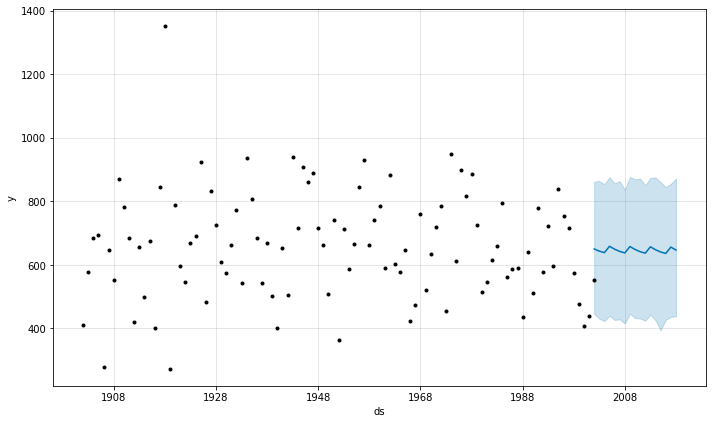

In [73]:
# forecasts with different train and test sizes
# 85% train, 15% test

training_X = fitting.loc[:100]
training_y = fitting.loc[:100].drop(['ds','t'], axis=1)
testing_X = fitting.loc[100:]
testing_y = fitting.loc[100:].drop(['ds','t'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [74]:
forecast_data.head(10)

ds        trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2001-12-31  2065.437951  446.123557  862.283385  2065.437951  2065.437951   
1 2002-12-31  2066.021331  430.669410  863.839318  2066.021331  2066.021331   
2 2003-12-31  2066.604710  423.347434  853.869274  2066.604710  2066.604710   
3 2004-12-31  2067.189688  440.371231  876.032059  2067.189688  2067.189688   
4 2005-12-31  2067.773067  426.867049  856.835721  2067.773067  2067.773067   
5 2006-12-31  2068.356447  428.935155  863.408597  2068.356447  2068.356447   
6 2007-12-31  2068.939826  415.375306  837.082148  2068.939826  2068.939826   
7 2008-12-31  2069.524804  446.519873  876.818502  2069.524804  2069.524804   
8 2009-12-31  2070.108184  432.688077  869.130999  2070.108184  2070.108184   
9 2010-12-31  2070.691563  431.677483  871.508415  2070.691563  2070.691563   

   additive_terms  additive_terms_lower  additive_terms_upper  \
0    -1415.198534          -1415.198534          -1415.198534   
1    -1422.741015          -1422.741015          -1422.741015   
2    -1427.959072          -1427.959072          -1427.959072   
3    -1408.524726          -1408.524726          -1408.524726   
4    -1418.383424          -1418.383424          -1418.383424   
5    -1425.925906          -1425.925906          -1425.925906   
6    -1431.143962          -1431.143962          -1431.143962   
7    -1411.709617          -1411.709617          -1411.709617   
8    -1421.568315          -1421.568315          -1421.568315   
9    -1429.110796          -1429.110796          -1429.110796   

   extra_regressors_additive  ...            t      t_lower      t_upper  \
0                1845.514003  ...  1845.514003  1845.514003  1845.514003   
1                1844.718325  ...  1844.718325  1844.718325  1844.718325   
2                1843.922648  ...  1843.922648  1843.922648  1843.922648   
3                1843.124790  ...  1843.124790  1843.124790  1843.124790   
4                1842.329113  ...  1842.329113  1842.329113  1842.329113   
5                1841.533435  ...  1841.533435  1841.533435  1841.533435   
6                1840.737757  ...  1840.737757  1840.737757  1840.737757   
7                1839.939900  ...  1839.939900  1839.939900  1839.939900   
8                1839.144222  ...  1839.144222  1839.144222  1839.144222   
9                1838.348544  ...  1838.348544  1838.348544  1838.348544   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0 -3260.712537  -3260.712537  -3260.712537                   0.0   
1 -3267.459340  -3267.459340  -3267.459340                   0.0   
2 -3271.881720  -3271.881720  -3271.881720                   0.0   
3 -3251.649516  -3251.649516  -3251.649516                   0.0   
4 -3260.712537  -3260.712537  -3260.712537                   0.0   
5 -3267.459340  -3267.459340  -3267.459340                   0.0   
6 -3271.881720  -3271.881720  -3271.881720                   0.0   
7 -3251.649516  -3251.649516  -3251.649516                   0.0   
8 -3260.712537  -3260.712537  -3260.712537                   0.0   
9 -3267.459340  -3267.459340  -3267.459340                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  650.239417  
1                         0.0                         0.0  643.280316  
2                         0.0                         0.0  638.645638  
3                         0.0                         0.0  658.664962  
4                         0.0                         0.0  649.389643  
5                         0.0                         0.0  642.430541  
6                         0.0                         0.0  637.795864  
7                         0.0                         0.0  657.815187  
8                         0.0                         0.0  648.539869  
9                         0.0                         0.0  641.580767  

[10 rows x 22 columns]

In [75]:
forecast_data.to_csv("fbprophet_multivar_85train_15_test.csv")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


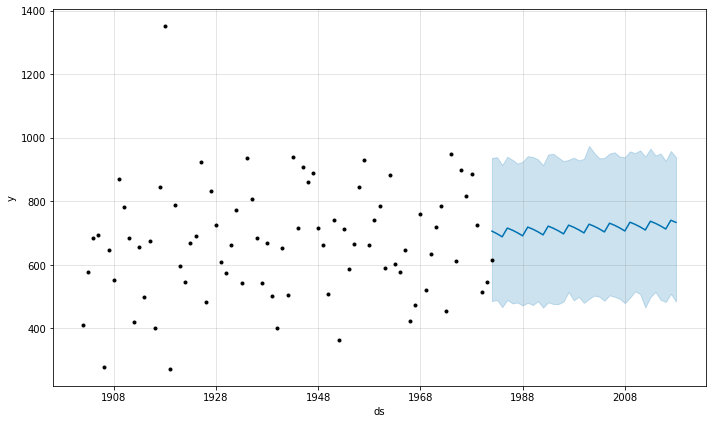

In [76]:
# forecasts with different train and test sizes
# 70% train, 30% test
training_X = fitting.loc[:80]
training_y = fitting.loc[:80].drop(['ds','t'], axis=1)
testing_X = fitting.loc[80:]
testing_y = fitting.loc[80:].drop(['ds','t'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [77]:
forecast_data.head(70)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  1981-12-31 -230.316337  486.183077  936.759223  -230.316337  -230.316337   
1  1982-12-31 -230.163549  489.735515  938.786687  -230.163549  -230.163549   
2  1983-12-31 -230.010761  466.943849  913.949321  -230.010761  -230.010761   
3  1984-12-31 -229.857555  489.838652  940.301989  -229.857555  -229.857555   
4  1985-12-31 -229.704767  479.194714  930.622250  -229.704767  -229.704767   
5  1986-12-31 -229.551979  481.595312  918.910177  -229.551979  -229.551979   
6  1987-12-31 -229.399192  472.355127  924.287067  -229.399192  -229.399192   
7  1988-12-31 -229.245985  481.001506  941.918818  -229.245985  -229.245985   
8  1989-12-31 -229.093198  473.840484  939.596938  -229.093198  -229.093198   
9  1990-12-31 -228.940410  485.759246  931.889597  -228.940410  -228.940410   
10 1991-12-31 -228.787622  465.770124  913.392560  -228.787622  -228.787622   
11 1992-12-31 -228.634416  482.349757  947.246401  -228.634416  -228.634416   
12 1993-12-31 -228.481628  477.060890  949.597265  -228.481628  -228.481628   
13 1994-12-31 -228.328841  476.860523  937.734313  -228.328841  -228.328841   
14 1995-12-31 -228.176053  484.764122  926.213850  -228.176053  -228.176053   
15 1996-12-31 -228.022847  514.857698  930.382312  -228.022847  -228.022847   
16 1997-12-31 -227.870059  488.612937  937.387631  -227.870059  -227.870059   
17 1998-12-31 -227.717271  499.600812  928.788458  -227.717271  -227.717271   
18 1999-12-31 -227.564484  480.609557  933.601101  -227.564484  -227.564484   
19 2000-12-31 -227.411277  493.014158  974.179165  -227.411277  -227.411277   
20 2001-12-31 -227.258490  503.411168  952.434229  -227.258490  -227.258490   
21 2002-12-31 -227.105702  500.230554  935.247792  -227.105702  -227.105702   
22 2003-12-31 -226.952914  487.221644  936.550181  -226.952914  -226.952914   
23 2004-12-31 -226.799708  504.490819  950.059964  -226.799708  -226.799708   
24 2005-12-31 -226.646920  499.548164  954.108550  -226.646920  -226.646920   
25 2006-12-31 -226.494133  493.330599  940.692121  -226.494133  -226.494133   
26 2007-12-31 -226.341345  479.878323  938.496738  -226.341345  -226.341345   
27 2008-12-31 -226.188139  496.768479  957.116658  -226.188139  -226.188139   
28 2009-12-31 -226.035351  516.901260  951.663366  -226.035351  -226.035351   
29 2010-12-31 -225.882563  508.378352  960.251423  -225.882563  -225.882563   
30 2011-12-31 -225.729776  466.163125  940.555809  -225.729776  -225.729776   
31 2012-12-31 -225.576569  498.710131  965.788802  -225.576569  -225.576569   
32 2013-12-31 -225.423782  515.062069  944.314739  -225.423782  -225.423782   
33 2014-12-31 -225.270994  490.364895  950.183333  -225.270994  -225.270994   
34 2015-12-31 -225.118206  483.311032  926.863340  -225.118206  -225.118206   
35 2016-12-31 -224.965000  509.366125  958.388720  -224.965000  -224.965000   
36 2017-12-31 -224.812212  484.627747  938.750292  -224.812212  -224.812212   

    additive_terms  additive_terms_lower  additive_terms_upper  \
0       936.492444            936.492444            936.492444   
1       928.183470            928.183470            928.183470   
2       918.433190            918.433190            918.433190   
3       945.798917            945.798917            945.798917   
4       938.941593            938.941593            938.941593   
5       930.632619            930.632619            930.632619   
6       920.882339            920.882339            920.882339   
7       948.248066            948.248066            948.248066   
8       941.390742            941.390742            941.390742   
9       933.081768            933.081768            933.081768   
10      923.331489            923.331489            923.331489   
11      950.697215            950.697215            950.697215   
12      943.839891            943.839891            943.839891   
13      935.530917            935.530917            935.530917   
14      925.780638

In [78]:
forecast_data.to_csv("fbprophet_multivar_70train_30_test.csv")

***

### Import Regressor Data
* The following regressors will be imported from downloaded data from the India Water Portal Met Data tool:
    - CC: Cloud cover (%)
    - VP: Vapor pressure (hpa)
    - WDF: Wet day frequency (days)
    - DTR: Diurnal temperature range (degrees celcius)
    - RCE: Reference crop evapotranspiration (mm/day)
    - PE: Potential evapotranspiration (mm/day)

* The data ranges from 1901 to 2002
* After importing the regressor data, dataframes to be used in Facebook Prophet forecast modeling will be created
* Temperature (degrees celcius) wil also be used as a regressor in the model

**Cloud Cover**

In [79]:
os.chdir(r'C:\\Users\\livsh\\Downloads') 
cloud_cover = pd.read_csv('cloud cover.csv')
cloud_cover.head()

Year     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug  \
0  1901  12.235  10.767  22.487  19.857  20.955  40.175  69.320  68.785   
1  1902  12.235  10.930  22.520  19.857  20.955  40.571  68.952  68.887   
2  1903  12.235  10.930  22.520  19.857  20.920  40.175  68.952  68.889   
3  1904  12.235  10.930  22.520  19.857  20.954  40.175  69.291  68.887   
4  1905  12.235  10.930  22.520  19.857  20.955  40.175  68.938  68.889   

      Sep     Oct     Nov    Dec  
0  45.478  15.947  10.085  9.857  
1  45.309  15.949  10.085  9.857  
2  45.478  15.944  10.085  9.857  
3  45.478  15.949  10.071  9.857  
4  45.478  15.949  10.085  9.857

In [80]:
# create the average for annual average cloud cover 
# create the average for each seasons (JF, MAM, JJAS, OND)

cloud_cover['JF'] = cloud_cover.loc[: , "Jan":"Feb"].mean(axis=1)
cloud_cover['MAM'] = cloud_cover.loc[: , "Mar":"May"].mean(axis=1)
cloud_cover['JJAS'] = cloud_cover.loc[: , "Jun":"Sep"].mean(axis=1)
cloud_cover['OND'] = cloud_cover.loc[: , "Oct":"Dec"].mean(axis=1)

cloud_cover['Mean'] = cloud_cover.loc[: , "Jan":"Dec"].mean(axis=1)
cloud_cover.head()

Year     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug  \
0  1901  12.235  10.767  22.487  19.857  20.955  40.175  69.320  68.785   
1  1902  12.235  10.930  22.520  19.857  20.955  40.571  68.952  68.887   
2  1903  12.235  10.930  22.520  19.857  20.920  40.175  68.952  68.889   
3  1904  12.235  10.930  22.520  19.857  20.954  40.175  69.291  68.887   
4  1905  12.235  10.930  22.520  19.857  20.955  40.175  68.938  68.889   

      Sep     Oct     Nov    Dec       JF        MAM      JJAS        OND  \
0  45.478  15.947  10.085  9.857  11.5010  21.099667  55.93950  11.963000   
1  45.309  15.949  10.085  9.857  11.5825  21.110667  55.92975  11.963667   
2  45.478  15.944  10.085  9.857  11.5825  21.099000  55.87350  11.962000   
3  45.478  15.949  10.071  9.857  11.5825  21.110333  55.95775  11.959000   
4  45.478  15.949  10.085  9.857  11.5825  21.110667  55.87000  11.963667   

        Mean  
0  28.829000  
1  28.842250  
2  28.820167  
3  28.850333  
4  28.822333

In [81]:
cc_describe = cloud_cover.describe().T
cc_describe

count         mean        std          min          25%          50%  \
Year  102.0  1951.500000  29.588849  1901.000000  1926.250000  1951.500000   
Jan   102.0    12.335853   2.506702     7.401000    11.140750    12.235000   
Feb   102.0    10.841627   3.220931     0.578000    10.225750    10.930000   
Mar   102.0    22.455667   3.168143    11.851000    21.289750    22.520000   
Apr   102.0    18.782971   3.148615     9.206000    17.403000    19.857000   
May   102.0    20.376794   2.830951    11.251000    19.534000    20.955000   
Jun   102.0    39.134814   4.247102    18.644000    37.686750    40.175000   
Jul   102.0    68.224686   3.035939    57.920000    67.375750    68.952000   
Aug   102.0    68.647196   2.254390    60.926000    67.612500    68.887000   
Sep   102.0    44.811196   3.933804    30.078000    42.989000    45.476000   
Oct   102.0    15.372480   4.116397     4.638000    13.792500    15.944000   
Nov   102.0     8.715539   4.803345     0.003000     5.469500    10.041000   
Dec   102.0     9.313392   2.739517     3.728000     7.968500     9.857000   
JF    102.0    11.588740   2.139209     5.325000    11.093875    11.582500   
MAM   102.0    20.538477   1.956631    12.455333    19.787083    21.096667   
JJAS  102.0    55.204473   2.262921    48.155250    53.716250    55.845125   
OND   102.0    11.133804   2.826454     3.722000     9.583417    11.930000   
Mean  102.0    28.251018   1.513548    23.475583    27.289687    28.797708   

              75%          max  
Year  1976.750000  2002.000000  
Jan     13.059500    20.208000  
Feb     12.002500    20.646000  
Mar     23.216750    32.831000  
Apr     19.915500    26.804000  
May     21.576750    31.721000  
Jun     40.667750    49.359000  
Jul     69.500250    75.741000  
Aug     69.405500    76.902000  
Sep     45.615750    60.614000  
Oct     16.222000    27.597000  
Nov     10.109750    26.869000  
Dec     10.058250    23.032000  
JF      12.380625    18.386500  
MAM     21.147417    28.366333  
JJAS    56.064750    59.977250  
OND     12.154333    21.436000  
Mean    28.895625    31.761000

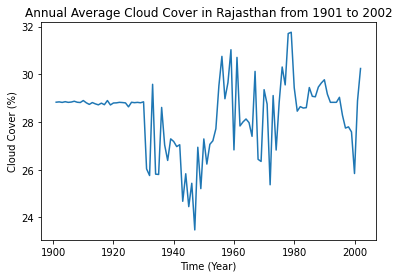

In [82]:
# can see trends of the annual cloudcover from 1901 to 2002
# using matplotlib for visualization 

fig, ax = plt.subplots()
ax.plot(cloud_cover['Year'], cloud_cover['Mean'])

ax.set_xlabel('Time (Year)')
ax.set_ylabel('Cloud Cover (%)')
ax.set_title('Annual Average Cloud Cover in Rajasthan from 1901 to 2002');

**Vapor Pressure**

In [83]:
os.chdir(r'C:\\Users\\livsh\\Downloads') 
vap_pressure = pd.read_csv('vapor pressure.csv')
vap_pressure.head()

Year    Jan    Feb    Mar     Apr     May     Jun     Jul     Aug     Sep  \
0  1901  6.668  6.562  8.735  11.876  18.264  27.514  29.428  26.466  24.970   
1  1902  7.761  7.473  9.665  12.750  18.040  25.828  29.420  28.635  24.395   
2  1903  7.300  7.226  7.537  10.982  17.887  27.473  29.459  26.506  24.915   
3  1904  7.286  7.530  8.145  12.047  17.961  25.684  27.605  26.514  24.933   
4  1905  6.689  5.722  7.537  10.690  19.504  25.749  27.973  28.205  25.072   

      Oct     Nov    Dec  
0  14.452   9.708  8.526  
1  13.551   9.272  7.769  
2  13.037   8.466  7.564  
3  13.553   9.023  8.223  
4  13.921  10.017  8.223

In [84]:
# create the average for annual average vapor pressure
# create the average for each seasons (JF, MAM, JJAS, OND)

vap_pressure['JF'] = vap_pressure.loc[: , "Jan":"Feb"].mean(axis=1)
vap_pressure['MAM'] = vap_pressure.loc[: , "Mar":"May"].mean(axis=1)
vap_pressure['JJAS'] = vap_pressure.loc[: , "Jun":"Sep"].mean(axis=1)
vap_pressure['OND'] = vap_pressure.loc[: , "Oct":"Dec"].mean(axis=1)

vap_pressure['Mean'] = vap_pressure.loc[: , "Jan":"Dec"].mean(axis=1)
vap_pressure.head()

Year    Jan    Feb    Mar     Apr     May     Jun     Jul     Aug     Sep  \
0  1901  6.668  6.562  8.735  11.876  18.264  27.514  29.428  26.466  24.970   
1  1902  7.761  7.473  9.665  12.750  18.040  25.828  29.420  28.635  24.395   
2  1903  7.300  7.226  7.537  10.982  17.887  27.473  29.459  26.506  24.915   
3  1904  7.286  7.530  8.145  12.047  17.961  25.684  27.605  26.514  24.933   
4  1905  6.689  5.722  7.537  10.690  19.504  25.749  27.973  28.205  25.072   

      Oct     Nov    Dec      JF        MAM      JJAS        OND       Mean  
0  14.452   9.708  8.526  6.6150  12.958333  27.09450  10.895333  16.097417  
1  13.551   9.272  7.769  7.6170  13.485000  27.06950  10.197333  16.213250  
2  13.037   8.466  7.564  7.2630  12.135333  27.08825   9.689000  15.696000  
3  13.553   9.023  8.223  7.4080  12.717667  26.18400  10.266333  15.708667  
4  13.921  10.017  8.223  6.2055  12.577000  26.74975  10.720333  15.775167

In [85]:
vp_describe = vap_pressure.describe().T
vp_describe

count         mean        std          min          25%          50%  \
Year  102.0  1951.500000  29.588849  1901.000000  1926.250000  1951.500000   
Jan   102.0     7.243804   0.430177     6.164000     7.033250     7.266000   
Feb   102.0     7.706176   0.614857     5.722000     7.259750     7.664000   
Mar   102.0     8.705843   0.601400     7.537000     8.258250     8.735000   
Apr   102.0    11.788000   0.688242    10.395000    11.196750    11.897000   
May   102.0    18.082157   0.680116    16.101000    17.903500    17.965500   
Jun   102.0    25.846373   0.967868    23.196000    25.627750    25.706500   
Jul   102.0    27.753863   0.955307    25.125000    27.567500    27.654500   
Aug   102.0    26.700157   0.712904    25.192000    26.439750    26.467500   
Sep   102.0    24.421304   0.801841    22.912000    24.258500    24.364500   
Oct   102.0    13.477637   0.679177    11.792000    13.042000    13.554000   
Nov   102.0     9.472490   0.613430     8.173000     9.023000     9.639500   
Dec   102.0     8.098108   0.381843     7.242000     7.751750     8.205500   
JF    102.0     7.474990   0.410776     6.205500     7.267750     7.471250   
MAM   102.0    12.858667   0.463901    11.705000    12.536750    12.890333   
JJAS  102.0    26.180424   0.548239    25.113500    25.817000    26.096125   
OND   102.0    10.349412   0.440465     9.394667    10.084750    10.314500   
Mean  102.0    15.774659   0.280816    15.077917    15.597521    15.734625   

              75%          max  
Year  1976.750000  2002.000000  
Jan      7.356250     8.523000  
Feb      8.171500     9.499000  
Mar      8.993500    10.135000  
Apr     12.188500    13.023000  
May     18.459750    19.504000  
Jun     25.838500    28.871000  
Jul     27.768750    31.130000  
Aug     26.513250    29.861000  
Sep     24.599750    27.538000  
Oct     13.866750    15.354000  
Nov      9.728250    10.714000  
Dec      8.275750     9.220000  
JF       7.723000     8.629000  
MAM     13.175917    13.950333  
JJAS    26.478187    28.267000  
OND     10.658667    11.391333  
Mean    15.941125    16.807833

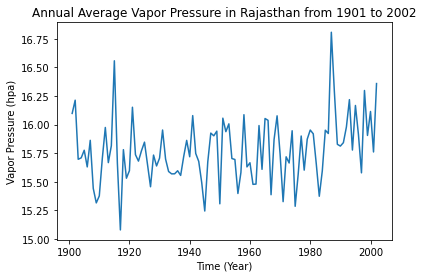

In [86]:
# can see trends of the annual average vapor pressure from 1901 to 2002
# using matplotlib for visualization 

fig, ax = plt.subplots()
ax.plot(vap_pressure['Year'], vap_pressure['Mean'])

ax.set_xlabel('Time (Year)')
ax.set_ylabel('Vapor Pressure (hpa)')
ax.set_title('Annual Average Vapor Pressure in Rajasthan from 1901 to 2002');

**Wet Day Frequency**

In [87]:
os.chdir(r'C:\\Users\\livsh\\Downloads') 
wet_day_freq = pd.read_csv('wet day frequency.csv')
wet_day_freq.head()

Year     Jan     Feb     Mar     Apr     May     Jun      Jul      Aug  \
0  1901  0.8488  0.0000  0.4876  0.2256  1.0014  2.9536  11.0708   8.5743   
1  1902  0.5648  0.0000  0.0000  0.0000  1.0014  3.5376   5.8210  10.0984   
2  1903  0.0909  0.0742  0.4987  0.0000  1.0517  1.5593  13.7434  10.7050   
3  1904  0.3164  0.6851  0.9999  0.0000  1.0014  2.7085   6.8743   5.1013   
4  1905  0.8167  0.5946  0.9723  0.9631  0.6867  1.9895  10.4618   3.2844   

      Sep     Oct     Nov     Dec  
0  1.5326  1.6500  0.1559  0.9827  
1  6.1911  0.7340  1.0293  0.4864  
2  5.6648  0.3289  0.1559  0.0000  
3  4.2136  1.3409  0.1559  0.9844  
4  4.5135  0.0023  0.1957  0.0000

In [88]:
# create the average for annual average wet day frequency
# create the average for each seasons (JF, MAM, JJAS, OND)
wet_day_freq['JF'] = wet_day_freq.loc[: , "Jan":"Feb"].mean(axis=1)
wet_day_freq['MAM'] = wet_day_freq.loc[: , "Mar":"May"].mean(axis=1)
wet_day_freq['JJAS'] = wet_day_freq.loc[: , "Jun":"Sep"].mean(axis=1)
wet_day_freq['OND'] = wet_day_freq.loc[: , "Oct":"Dec"].mean(axis=1)

wet_day_freq['Mean'] = wet_day_freq.loc[: , "Jan":"Dec"].mean(axis=1)
wet_day_freq.head()

Year     Jan     Feb     Mar     Apr     May     Jun      Jul      Aug  \
0  1901  0.8488  0.0000  0.4876  0.2256  1.0014  2.9536  11.0708   8.5743   
1  1902  0.5648  0.0000  0.0000  0.0000  1.0014  3.5376   5.8210  10.0984   
2  1903  0.0909  0.0742  0.4987  0.0000  1.0517  1.5593  13.7434  10.7050   
3  1904  0.3164  0.6851  0.9999  0.0000  1.0014  2.7085   6.8743   5.1013   
4  1905  0.8167  0.5946  0.9723  0.9631  0.6867  1.9895  10.4618   3.2844   

      Sep     Oct     Nov     Dec       JF       MAM      JJAS       OND  \
0  1.5326  1.6500  0.1559  0.9827  0.42440  0.571533  6.032825  0.929533   
1  6.1911  0.7340  1.0293  0.4864  0.28240  0.333800  6.412025  0.749900   
2  5.6648  0.3289  0.1559  0.0000  0.08255  0.516800  7.918125  0.161600   
3  4.2136  1.3409  0.1559  0.9844  0.50075  0.667100  4.724425  0.827067   
4  4.5135  0.0023  0.1957  0.0000  0.70565  0.874033  5.062300  0.066000   

       Mean  
0  2.456942  
1  2.455333  
2  2.822733  
3  2.031808  
4  2.040050

In [89]:
wdf_describe = wet_day_freq.describe().T
wdf_describe

count         mean        std          min          25%          50%  \
Year  102.0  1951.500000  29.588849  1901.000000  1926.250000  1951.500000   
Jan   102.0     0.517035   0.427758     0.000000     0.000000     0.572350   
Feb   102.0     0.324525   0.357683     0.000000     0.000000     0.128600   
Mar   102.0     0.413764   0.433681     0.000000     0.000000     0.223750   
Apr   102.0     0.437277   0.423321     0.000000     0.000000     0.411900   
May   102.0     0.817565   0.381792     0.003100     0.686700     1.001400   
Jun   102.0     3.909954   1.464530     0.980400     2.960200     3.777650   
Jul   102.0    10.422068   2.500687     3.175300     8.987175    10.691050   
Aug   102.0    10.184664   2.909405     2.258800     8.411050    10.090950   
Sep   102.0     4.890166   2.206299     1.031500     3.318575     4.570750   
Oct   102.0     1.001105   0.793528     0.002300     0.137525     1.107200   
Nov   102.0     0.851297   0.778792     0.155900     0.155900     0.562050   
Dec   102.0     0.411546   0.428860     0.000000     0.000000     0.294200   
JF    102.0     0.420780   0.271995     0.000000     0.210125     0.443575   
MAM   102.0     0.556202   0.256847     0.001033     0.359725     0.560167   
JJAS  102.0     7.351713   1.261574     4.452400     6.563119     7.338612   
OND   102.0     0.754649   0.412857     0.052733     0.474292     0.739500   
Mean  102.0     2.848414   0.446445     1.817150     2.526100     2.843029   

              75%          max  
Year  1976.750000  2002.000000  
Jan      0.984400     0.999900  
Feb      0.704000     1.023800  
Mar      0.934125     0.999900  
Apr      0.970150     0.999900  
May      1.029625     1.503100  
Jun      4.847425     7.204700  
Jul     11.944525    16.194900  
Aug     12.471125    15.463100  
Sep      6.472000     9.604300  
Oct      1.473775     2.842100  
Nov      1.207400     2.906000  
Dec      0.966275     0.999900  
JF       0.541375     0.944600  
MAM      0.693233     1.085500  
JJAS     8.162325     9.892025  
OND      1.026342     1.854833  
Mean     3.183462     3.837183

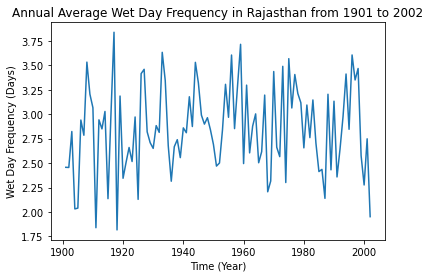

In [90]:
# can see trends of the annual average wet day frequency from 1901 to 2002
# using matplotlib for visualization 

fig, ax = plt.subplots()
ax.plot(wet_day_freq['Year'], wet_day_freq['Mean'])

ax.set_xlabel('Time (Year)')
ax.set_ylabel('Wet Day Frequency (Days)')
ax.set_title('Annual Average Wet Day Frequency in Rajasthan from 1901 to 2002');

**Diurnal Temperature Range**

In [91]:
os.chdir(r'C:\\Users\\livsh\\Downloads') 
diurnal_temp_range = pd.read_csv('diurnal temperature range.csv')
diurnal_temp_range.head()

Year   Jan     Feb     Mar     Apr     May     Jun    Jul   Aug    Sep  \
0  1901  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
1  1902  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
2  1903  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
3  1904  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
4  1905  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   

      Oct     Nov     Dec  
0  14.474  15.628  15.792  
1  14.474  15.628  15.792  
2  14.474  15.628  15.792  
3  14.474  15.628  15.792  
4  14.474  15.628  15.792

In [92]:
# create the average for annual average diurnal temperature range
# create the average for each seasons (JF, MAM, JJAS, OND)
diurnal_temp_range['JF'] = diurnal_temp_range.loc[: , "Jan":"Feb"].mean(axis=1)
diurnal_temp_range['MAM'] = diurnal_temp_range.loc[: , "Mar":"May"].mean(axis=1)
diurnal_temp_range['JJAS'] = diurnal_temp_range.loc[: , "Jun":"Sep"].mean(axis=1)
diurnal_temp_range['OND'] = diurnal_temp_range.loc[: , "Oct":"Dec"].mean(axis=1)

diurnal_temp_range['Mean'] = diurnal_temp_range.loc[: , "Jan":"Dec"].mean(axis=1)
diurnal_temp_range.head()

Year   Jan     Feb     Mar     Apr     May     Jun    Jul   Aug    Sep  \
0  1901  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
1  1902  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
2  1903  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
3  1904  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   
4  1905  15.8  16.082  16.135  15.227  14.248  11.256  7.658  6.67  9.284   

      Oct     Nov     Dec      JF        MAM   JJAS     OND       Mean  
0  14.474  15.628  15.792  15.941  15.203333  8.717  15.298  13.187833  
1  14.474  15.628  15.792  15.941  15.203333  8.717  15.298  13.187833  
2  14.474  15.628  15.792  15.941  15.203333  8.717  15.298  13.187833  
3  14.474  15.628  15.792  15.941  15.203333  8.717  15.298  13.187833  
4  14.474  15.628  15.792  15.941  15.203333  8.717  15.298  13.187833

In [93]:
dtr_describe = diurnal_temp_range.describe().T
dtr_describe

count         mean        std          min          25%          50%  \
Year  102.0  1951.500000  29.588849  1901.000000  1926.250000  1951.500000   
Jan   102.0    15.803255   0.163917    14.768000    15.800000    15.800000   
Feb   102.0    16.088402   0.121394    15.649000    16.082000    16.082000   
Mar   102.0    16.135461   0.076316    15.920000    16.135000    16.135000   
Apr   102.0    15.224765   0.076413    14.925000    15.227000    15.227000   
May   102.0    14.250980   0.149917    13.814000    14.248000    14.248000   
Jun   102.0    11.255147   0.056928    11.035000    11.256000    11.256000   
Jul   102.0     7.662853   0.088266     7.373000     7.658000     7.658000   
Aug   102.0     6.666775   0.054104     6.401000     6.670000     6.670000   
Sep   102.0     9.286108   0.142205     8.718000     9.284000     9.284000   
Oct   102.0    14.478373   0.100411    14.218000    14.474000    14.474000   
Nov   102.0    15.619725   0.153773    14.964000    15.628000    15.628000   
Dec   102.0    15.798735   0.142323    14.684000    15.792000    15.792000   
JF    102.0    15.945828   0.099788    15.425000    15.941000    15.941000   
MAM   102.0    15.203735   0.069780    14.975000    15.203333    15.203333   
JJAS  102.0     8.717721   0.046320     8.579750     8.717000     8.717000   
OND   102.0    15.298944   0.080108    14.888000    15.298000    15.298000   
Mean  102.0    13.189215   0.033759    13.086667    13.187833    13.187833   

              75%          max  
Year  1976.750000  2002.000000  
Jan     15.800000    16.760000  
Feb     16.082000    16.904000  
Mar     16.135000    16.537000  
Apr     15.227000    15.598000  
May     14.248000    15.475000  
Jun     11.256000    11.632000  
Jul      7.658000     8.123000  
Aug      6.670000     6.919000  
Sep      9.284000    10.066000  
Oct     14.474000    15.190000  
Nov     15.628000    16.497000  
Dec     15.792000    16.334000  
JF      15.941000    16.421000  
MAM     15.203333    15.635000  
JJAS     8.717000     8.915500  
OND     15.298000    15.621667  
Mean    13.187917    13.354083

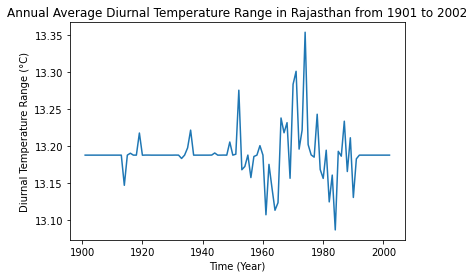

In [94]:
# data visualization
# can see trends of the annual average diurnal temperature range from 1901 to 2002
# using matplotlib for visualization 

fig, ax = plt.subplots()
ax.plot(diurnal_temp_range['Year'], diurnal_temp_range['Mean'])

ax.set_xlabel('Time (Year)')
ax.set_ylabel('Diurnal Temperature Range (°C)')
ax.set_title('Annual Average Diurnal Temperature Range in Rajasthan from 1901 to 2002');

**Referece Crop Evapotranspirtation**

In [95]:
os.chdir(r'C:\\Users\\livsh\\Downloads') 
ref_crop_evap = pd.read_csv('reference crop evapotranspirtation.csv')
ref_crop_evap.head()

Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1901  3.05  3.80  5.49  6.61  7.30  6.62  5.05  4.27  4.62  4.93  3.79   
1  1902  3.29  4.09  5.69  6.78  7.24  6.43  5.08  4.41  4.58  4.82  3.72   
2  1903  3.16  3.86  5.16  6.44  7.22  6.59  5.04  4.28  4.59  4.79  3.57   
3  1904  3.16  4.01  5.26  6.69  7.24  6.35  4.88  4.27  4.61  4.82  3.74   
4  1905  3.06  3.52  5.10  6.33  7.45  6.45  4.93  4.34  4.63  4.86  3.88   

    Dec  
0  3.18  
1  3.07  
2  3.01  
3  3.10  
4  3.10

In [96]:
# create the average for annual reference crop evapotranspiration
# create the average for each seasons (JF, MAM, JJAS, OND)
ref_crop_evap['JF'] = ref_crop_evap.loc[: , "Jan":"Feb"].mean(axis=1)
ref_crop_evap['MAM'] = ref_crop_evap.loc[: , "Mar":"May"].mean(axis=1)
ref_crop_evap['JJAS'] = ref_crop_evap.loc[: , "Jun":"Sep"].mean(axis=1)
ref_crop_evap['OND'] = ref_crop_evap.loc[: , "Oct":"Dec"].mean(axis=1)

ref_crop_evap['Mean'] = ref_crop_evap.loc[: , "Jan":"Dec"].mean(axis=1)
ref_crop_evap.head()

Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1901  3.05  3.80  5.49  6.61  7.30  6.62  5.05  4.27  4.62  4.93  3.79   
1  1902  3.29  4.09  5.69  6.78  7.24  6.43  5.08  4.41  4.58  4.82  3.72   
2  1903  3.16  3.86  5.16  6.44  7.22  6.59  5.04  4.28  4.59  4.79  3.57   
3  1904  3.16  4.01  5.26  6.69  7.24  6.35  4.88  4.27  4.61  4.82  3.74   
4  1905  3.06  3.52  5.10  6.33  7.45  6.45  4.93  4.34  4.63  4.86  3.88   

    Dec     JF       MAM    JJAS       OND      Mean  
0  3.18  3.425  6.466667  5.1400  3.966667  4.892500  
1  3.07  3.690  6.570000  5.1250  3.870000  4.933333  
2  3.01  3.510  6.273333  5.1250  3.790000  4.809167  
3  3.10  3.585  6.396667  5.0275  3.886667  4.844167  
4  3.10  3.290  6.293333  5.0875  3.946667  4.804167

In [97]:
rce_describe = ref_crop_evap.describe().T
rce_describe

count         mean        std          min          25%          50%  \
Year  102.0  1951.500000  29.588849  1901.000000  1926.250000  1951.500000   
Jan   102.0     3.161863   0.091584     2.980000     3.100000     3.150000   
Feb   102.0     3.999118   0.137712     3.520000     3.930000     3.990000   
Mar   102.0     5.420196   0.147916     5.100000     5.300000     5.430000   
Apr   102.0     6.592157   0.143938     6.260000     6.490000     6.600000   
May   102.0     7.196471   0.127595     6.840000     7.122500     7.210000   
Jun   102.0     6.393529   0.117209     6.080000     6.300000     6.390000   
Jul   102.0     4.893725   0.099144     4.630000     4.822500     4.890000   
Aug   102.0     4.227353   0.069921     4.110000     4.180000     4.220000   
Sep   102.0     4.543039   0.100038     4.310000     4.470000     4.530000   
Oct   102.0     4.789314   0.109148     4.510000     4.730000     4.790000   
Nov   102.0     3.757941   0.113603     3.560000     3.675000     3.750000   
Dec   102.0     3.102059   0.070407     2.940000     3.050000     3.100000   
JF    102.0     3.580490   0.090473     3.290000     3.531250     3.575000   
MAM   102.0     6.402941   0.100089     6.170000     6.314167     6.398333   
JJAS  102.0     5.014412   0.065237     4.910000     4.967500     5.015000   
OND   102.0     3.883105   0.077674     3.736667     3.827500     3.881667   
Mean  102.0     4.839730   0.048899     4.725000     4.809167     4.833750   

              75%          max  
Year  1976.750000  2002.000000  
Jan      3.227500     3.390000  
Feb      4.080000     4.360000  
Mar      5.507500     5.730000  
Apr      6.697500     6.870000  
May      7.297500     7.450000  
Jun      6.470000     6.700000  
Jul      4.957500     5.130000  
Aug      4.270000     4.470000  
Sep      4.607500     4.820000  
Oct      4.867500     5.070000  
Nov      3.820000     4.070000  
Dec      3.140000     3.270000  
JF       3.628750     3.835000  
MAM      6.493333     6.586667  
JJAS     5.052500     5.205000  
OND      3.935833     4.080000  
Mean     4.877500     4.971667

* The reference crop evapotranspiration is the greatest in the MAM season and the least in JF (based on the mean)
* JJAS had an average of 5.014 mm/day for reference crop evapotranspiration

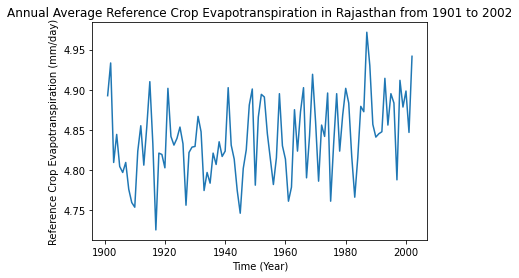

In [98]:
# data visualization
# can see trends of the annual average reference crop evapotranspiration from 1901 to 2002
# using matplotlib for visualization 

fig, ax = plt.subplots()
ax.plot(ref_crop_evap['Year'], ref_crop_evap['Mean'])

ax.set_xlabel('Time (Year)')
ax.set_ylabel('Reference Crop Evapotranspiration (mm/day)')
ax.set_title('Annual Average Reference Crop Evapotranspiration in Rajasthan from 1901 to 2002');

**Potential Evapotranspiration**
* Source: https://www.indiawaterportal.org/met_data/
* Units: mm/day

In [99]:
os.chdir(r'C:\\Users\\livsh\\Downloads') 
potential_evap = pd.read_csv('potential evapotranspiration.csv')
potential_evap.head()

Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1901  5.40  6.06  7.25  8.28  8.76  7.91  6.08  5.25  5.99  7.00  6.26   
1  1902  5.55  6.28  7.38  8.37  8.83  7.83  6.04  5.38  6.03  6.96  6.24   
2  1903  5.49  6.20  7.13  8.16  8.72  7.90  6.07  5.28  6.00  7.00  6.14   
3  1904  5.44  6.28  7.17  8.26  8.81  7.89  5.95  5.23  6.00  6.97  6.24   
4  1905  5.48  5.96  7.03  8.07  8.78  7.92  5.98  5.25  6.03  6.95  6.30   

    Dec  
0  5.56  
1  5.48  
2  5.41  
3  5.56  
4  5.60

In [100]:
# create the average for annaul potential evapotranspiration
# create the average for each seasons (JF, MAM, JJAS, OND)
potential_evap['JF'] = potential_evap.loc[: , "Jan":"Feb"].mean(axis=1)
potential_evap['MAM'] = potential_evap.loc[: , "Mar":"May"].mean(axis=1)
potential_evap['JJAS'] = potential_evap.loc[: , "Jun":"Sep"].mean(axis=1)
potential_evap['OND'] = potential_evap.loc[: , "Oct":"Dec"].mean(axis=1)

potential_evap['Mean'] = potential_evap.loc[: , "Jan":"Dec"].mean(axis=1)

potential_evap.head()

Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1901  5.40  6.06  7.25  8.28  8.76  7.91  6.08  5.25  5.99  7.00  6.26   
1  1902  5.55  6.28  7.38  8.37  8.83  7.83  6.04  5.38  6.03  6.96  6.24   
2  1903  5.49  6.20  7.13  8.16  8.72  7.90  6.07  5.28  6.00  7.00  6.14   
3  1904  5.44  6.28  7.17  8.26  8.81  7.89  5.95  5.23  6.00  6.97  6.24   
4  1905  5.48  5.96  7.03  8.07  8.78  7.92  5.98  5.25  6.03  6.95  6.30   

    Dec     JF       MAM    JJAS       OND    Mean  
0  5.56  5.730  8.096667  6.3075  6.273333  6.6500  
1  5.48  5.915  8.193333  6.3200  6.226667  6.6975  
2  5.41  5.845  8.003333  6.3125  6.183333  6.6250  
3  5.56  5.860  8.080000  6.2675  6.256667  6.6500  
4  5.60  5.720  7.960000  6.2950  6.283333  6.6125

In [101]:
pe_decribe = potential_evap.describe().T
pe_decribe

count         mean        std          min          25%          50%  \
Year  102.0  1951.500000  29.588849  1901.000000  1926.250000  1951.500000   
Jan   102.0     5.475000   0.086250     5.280000     5.402500     5.480000   
Feb   102.0     6.235588   0.119351     5.960000     6.160000     6.230000   
Mar   102.0     7.264216   0.109684     7.020000     7.190000     7.270000   
Apr   102.0     8.286176   0.097056     8.020000     8.230000     8.280000   
May   102.0     8.785686   0.081962     8.610000     8.732500     8.780000   
Jun   102.0     7.892451   0.098508     7.650000     7.830000     7.890000   
Jul   102.0     5.998824   0.097252     5.690000     5.952500     5.995000   
Aug   102.0     5.236078   0.069384     5.090000     5.190000     5.240000   
Sep   102.0     5.980882   0.107520     5.650000     5.940000     5.985000   
Oct   102.0     6.943137   0.096718     6.620000     6.890000     6.940000   
Nov   102.0     6.244706   0.089417     6.000000     6.180000     6.250000   
Dec   102.0     5.536471   0.081589     5.340000     5.480000     5.530000   
JF    102.0     5.855294   0.075593     5.705000     5.810000     5.855000   
MAM   102.0     8.112026   0.068233     7.960000     8.063333     8.101667   
JJAS  102.0     6.277059   0.058591     6.145000     6.242500     6.275000   
OND   102.0     6.241438   0.064403     6.066667     6.206667     6.235000   
Mean  102.0     6.656601   0.036729     6.565833     6.633750     6.653333   

              75%          max  
Year  1976.750000  2002.000000  
Jan      5.537500     5.680000  
Feb      6.310000     6.600000  
Mar      7.320000     7.600000  
Apr      8.347500     8.530000  
May      8.830000     9.100000  
Jun      7.930000     8.320000  
Jul      6.060000     6.210000  
Aug      5.277500     5.420000  
Sep      6.037500     6.290000  
Oct      7.007500     7.300000  
Nov      6.310000     6.480000  
Dec      5.590000     5.760000  
JF       5.898750     6.075000  
MAM      8.155833     8.266667  
JJAS     6.307500     6.430000  
OND      6.276667     6.426667  
Mean     6.677500     6.749167

* MAM has the greatest potential evapotranspiration rate and JF has the lowest potential evaportranspiraation rate
* This is similar observation for reference crop evapotranspiration

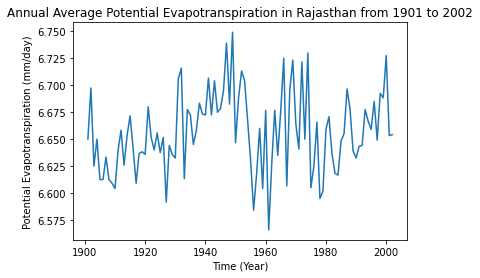

In [102]:
# data visualization
# can see trends of the annual average potential evapotranspiration from 1901 to 2002
# using matplotlib for visualization 

fig, ax = plt.subplots()
ax.plot(potential_evap['Year'], potential_evap['Mean'])

ax.set_xlabel('Time (Year)')
ax.set_ylabel('Potential Evapotranspiration (mm/day)')
ax.set_title('Annual Average Potential Evapotranspiration in Rajasthan from 1901 to 2002');

### Adding new regressors (data from 1901 to 2002)

In [103]:
# add more data

fitting = pd.DataFrame()  # define new dataframe

fitting['ds'] = p_new.iloc[0:102].index
display(fitting.head())
len(fitting)

ds
0 1901-12-31
1 1902-12-31
2 1903-12-31
3 1904-12-31
4 1905-12-31

102

In [104]:
fitting['y'] = annual_precip['Annual'].iloc[0:102].values
fitting['y']

0      412.5
1      578.3
2      686.1
3      694.5
4      279.8
       ...  
97     475.8
98     408.4
99     440.0
100    551.2
101    285.3
Name: y, Length: 102, dtype: float64

In [105]:
fitting['t'] = t.resample('A').mean()['Avg_Temp_deg_C'].iloc[0:102].values
# fill in NaN values - forward fill to fill in the missing values of the dataframe
fitting['t'].fillna(method='ffill', inplace=True)
fitting['t']

0      24.224167
1      24.326667
2      23.980833
3      23.850000
4      23.932500
         ...    
97     24.695000
98     24.660833
99     24.576667
100    24.814167
101    25.031667
Name: t, Length: 102, dtype: float64

In [106]:
# add regressors for climate data from Met Data Tool

fitting['CC'] = cloud_cover['Mean']
fitting['VP'] = vap_pressure['Mean']
fitting['WDF'] = wet_day_freq['Mean']
fitting['DTR'] = diurnal_temp_range['Mean']
fitting['RCE'] = ref_crop_evap['Mean']
fitting['PE'] = potential_evap['Mean']

In [107]:
fitting.head().T

0                    1                    2  \
ds   1901-12-31 00:00:00  1902-12-31 00:00:00  1903-12-31 00:00:00   
y                  412.5                578.3                686.1   
t                24.2242              24.3267              23.9808   
CC                28.829              28.8423              28.8202   
VP               16.0974              16.2132               15.696   
WDF              2.45694              2.45533              2.82273   
DTR              13.1878              13.1878              13.1878   
RCE               4.8925              4.93333              4.80917   
PE                  6.65               6.6975                6.625   

                       3                    4  
ds   1904-12-31 00:00:00  1905-12-31 00:00:00  
y                  694.5                279.8  
t                  23.85              23.9325  
CC               28.8503              28.8223  
VP               15.7087              15.7752  
WDF              2.03181              2.04005  
DTR              13.1878              13.1878  
RCE              4.84417              4.80417  
PE                  6.65               6.6125

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


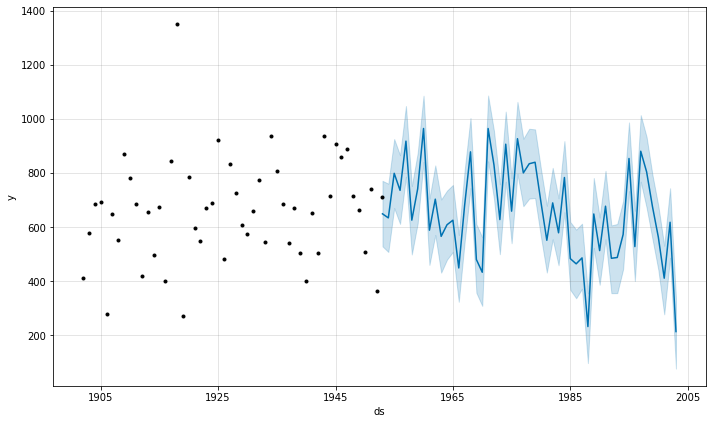

In [108]:
# 50% train, 50% test

training_X = fitting.loc[:51]
training_y = fitting.loc[:51].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)
testing_X = fitting.loc[51:]
testing_y = fitting.loc[51:].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')
pro_regressor.add_regressor('CC')
pro_regressor.add_regressor('VP')
pro_regressor.add_regressor('WDF')
pro_regressor.add_regressor('DTR')
pro_regressor.add_regressor('RCE')
pro_regressor.add_regressor('PE')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [109]:
display(forecast_data)

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  1952-12-31  768.089956  529.444416   771.741096   768.089956   768.089956   
1  1953-12-31  767.948366  508.615236   761.255121   767.948366   767.948366   
2  1954-12-31  767.806776  671.098569   926.216004   767.806776   767.806776   
3  1955-12-31  767.665186  612.484101   866.533044   767.665186   767.665186   
4  1956-12-31  767.523208  787.068303  1048.345377   767.523208   767.523208   
5  1957-12-31  767.381619  499.480823   752.494041   767.381619   767.381619   
6  1958-12-31  767.240029  614.206942   874.278566   767.240029   767.240029   
7  1959-12-31  767.098439  841.689492  1086.406713   767.098439   767.098439   
8  1960-12-31  766.956461  460.760087   705.711042   766.956461   766.956461   
9  1961-12-31  766.814871  571.468393   828.692955   766.814871   766.814871   
10 1962-12-31  766.673281  432.045582   702.662666   766.673281   766.673281   
11 1963-12-31  766.531691  480.562990   735.446405   766.531691   766.531691   
12 1964-12-31  766.389714  508.654577   756.493987   766.389714   766.389714   
13 1965-12-31  766.248124  324.356367   571.164790   766.248124   766.248124   
14 1966-12-31  766.106534  545.676830   810.289189   766.106534   766.106534   
15 1967-12-31  765.964944  744.669635  1003.992326   765.964944   765.964944   
16 1968-12-31  765.822966  357.682952   611.494499   765.822966   765.822966   
17 1969-12-31  765.681376  309.240277   562.924314   765.681376   765.681376   
18 1970-12-31  765.539787  843.865192  1087.138580   765.539787   765.539787   
19 1971-12-31  765.398197  705.688594   956.166288   765.398197   765.398197   
20 1972-12-31  765.256219  500.303215   758.763299   765.256219   765.256219   
21 1973-12-31  765.114629  768.552521  1027.676612   765.114629   765.114629   
22 1974-12-31  764.973039  540.908696   781.645444   764.973039   764.973039   
23 1975-12-31  764.831449  797.176473  1063.572169   764.831449   764.831449   
24 1976-12-31  764.689471  677.839159   927.150799   764.689471   764.689471   
25 1977-12-31  764.547882  705.942949   964.307062   764.547882   764.547882   
26 1978-12-31  764.406292  708.224599   961.915440   764.406292   764.406292   
27 1979-12-31  764.264702  565.042367   815.812194   764.264702   764.264702   
28 1980-12-31  764.122724  432.544617   679.634024   764.122724   764.122724   
29 1981-12-31  763.981134  555.778997   819.667815   763.981134   763.981134   
30 1982-12-31  763.839544  459.529757   707.049854   763.839544   763.839544   
31 1983-12-31  763.697955  655.488565   918.549619   763.697955   763.697955   
32 1984-12-31  763.555977  368.737959   619.395503   763.555977   763.555977   
33 1985-12-31  763.414387  337.469363   591.243611   763.414387   763.414387   
34 1986-12-31  763.272797  372.862073   613.309301   763.272797   763.272797   
35 1987-12-31  763.131207   97.721974   355.694862   763.131207   763.131207   
36 1988-12-31  762.989229  523.664283   782.250339   762.989229   762.989229   
37 1989-12-31  762.847639  387.323863   636.074960   762.847639   762.847639   
38 1990-12-31  762.706050  555.567541   808.701716   762.706050   762.706050   
39 1991-12-31  762.564460  356.225845   606.809281   762.564460   762.564460   
40 1992-12-31  762.422482  356.445053   612.060373   762.422482   762.422482   
41 1993-12-31  762.280892  445.252968   696.916109   762.280892   762.280892   
42 1994-12-31  762.139302  733.549428   987.668510   762.139302   762.139302   
43 1995-12-31  761.997712  401.139333   661.032964   761.997712   761.997712   
44 1996-12-31  761.855735  768.600280  1014.567239   761.855735   761.855735   
45 1997-12-31  761.714145  672.386946   933.876237   761.714145   761.714145   
46 1998-12-31  761.572555  556.435021   793.425324   761.572555   761.572555   
47 1999-12-31  761.430965  442.507075   678.873119   761.430965   761.430965   
48 2000-12-31  761.288987  278.103459   531.791158   761.288987   761.288987   
49 2001-12-

In [110]:
_50_50 = pd.DataFrame()
_50_50['ds'] = forecast_data['ds']
_50_50['predict'] = forecast_data['yhat']
_50_50['actual'] = fitting['y'].iloc[:51]

# apply percent error formula
_50_50['percent_error'] = (_50_50['predict'] - _50_50['actual'])/_50_50['actual']*100

# add to compare dataframe
compare = pd.DataFrame()
compare['ds'] = forecast_data['ds']
compare['actual'] = fitting['y'].iloc[:51]
compare['5050_predict'] = _50_50['predict']
compare['5050_diff'] = abs(_50_50['predict'] - _50_50['actual'])
compare['5050_pct_error'] = abs(_50_50['percent_error'])

# display dataframe
_50_50.head()

ds     predict  actual  percent_error
0 1952-12-31  649.755648   412.5      57.516521
1 1953-12-31  634.679403   578.3       9.749162
2 1954-12-31  799.521275   686.1      16.531304
3 1955-12-31  736.464621   694.5       6.042422
4 1956-12-31  918.542046   279.8     228.285220

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


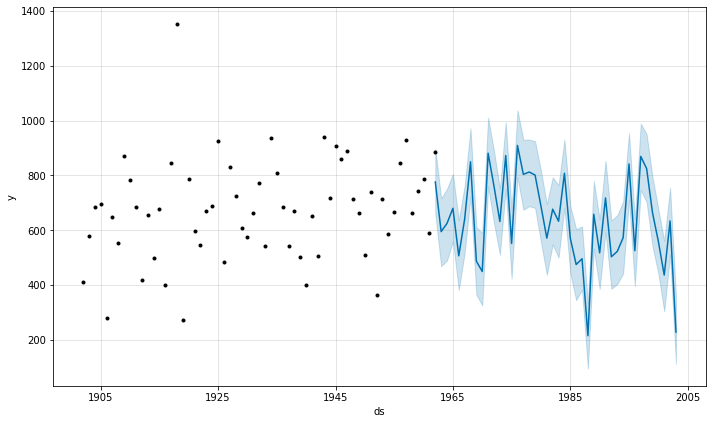

In [111]:
# forecasts with different train and test sizes
# 60% train, 40% test

training_X = fitting.loc[:60]
training_y = fitting.loc[:60].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)
testing_X = fitting.loc[60:]
testing_y = fitting.loc[60:].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')
pro_regressor.add_regressor('CC')
pro_regressor.add_regressor('VP')
pro_regressor.add_regressor('WDF')
pro_regressor.add_regressor('DTR')
pro_regressor.add_regressor('RCE')
pro_regressor.add_regressor('PE')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [112]:
display(forecast_data)

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  1961-12-31  706.976558  659.693806   897.086076   706.976558   706.976558   
1  1962-12-31  706.887070  469.309103   716.299651   706.887070   706.887070   
2  1963-12-31  706.797582  490.141879   751.385713   706.797582   706.797582   
3  1964-12-31  706.707850  560.038243   805.545339   706.707850   706.707850   
4  1965-12-31  706.618362  382.092325   636.447041   706.618362   706.618362   
5  1966-12-31  706.528874  516.916774   762.513631   706.528874   706.528874   
6  1967-12-31  706.439387  722.609066   971.312483   706.439387   706.439387   
7  1968-12-31  706.349654  364.608443   611.322271   706.349654   706.349654   
8  1969-12-31  706.260166  326.239775   589.764378   706.260166   706.260166   
9  1970-12-31  706.170678  760.256536  1010.489157   706.170678   706.170678   
10 1971-12-31  706.081191  626.877673   889.498265   706.081191   706.081191   
11 1972-12-31  705.991458  510.684998   750.759061   705.991458   705.991458   
12 1973-12-31  705.901970  749.837153   993.748233   705.901970   705.901970   
13 1974-12-31  705.812482  423.991373   674.169437   705.812482   705.812482   
14 1975-12-31  705.722995  793.960134  1037.855431   705.722995   705.722995   
15 1976-12-31  705.633262  674.695597   930.372221   705.633262   705.633262   
16 1977-12-31  705.543774  687.922313   930.908204   705.543774   705.543774   
17 1978-12-31  705.454287  681.564780   924.831304   705.454287   705.454287   
18 1979-12-31  705.364799  557.254490   817.720727   705.364799   705.364799   
19 1980-12-31  705.275066  437.832161   695.239086   705.275066   705.275066   
20 1981-12-31  705.185578  548.714660   793.084322   705.185578   705.185578   
21 1982-12-31  705.096091  500.337341   765.085948   705.096091   705.096091   
22 1983-12-31  705.006603  682.371770   930.211617   705.006603   705.006603   
23 1984-12-31  704.916870  442.478871   688.310863   704.916870   704.916870   
24 1985-12-31  704.827382  345.160737   604.107510   704.827382   704.827382   
25 1986-12-31  704.737895  383.135740   614.123165   704.737895   704.737895   
26 1987-12-31  704.648407   95.591207   331.903340   704.648407   704.648407   
27 1988-12-31  704.558674  532.981032   779.301689   704.558674   704.558674   
28 1989-12-31  704.469187  385.746473   639.187808   704.469187   704.469187   
29 1990-12-31  704.379699  595.168912   853.202139   704.379699   704.379699   
30 1991-12-31  704.290211  386.551202   635.461112   704.290211   704.290211   
31 1992-12-31  704.200478  403.922622   654.743796   704.200478   704.200478   
32 1993-12-31  704.110991  442.389333   704.377490   704.110991   704.110991   
33 1994-12-31  704.021503  712.133834   954.452199   704.021503   704.021503   
34 1995-12-31  703.932015  396.626430   641.090991   703.932015   703.932015   
35 1996-12-31  703.842282  747.495767   988.977210   703.842282   703.842282   
36 1997-12-31  703.752795  702.424939   950.988484   703.752795   703.752795   
37 1998-12-31  703.663307  541.985674   794.515801   703.663307   703.663307   
38 1999-12-31  703.573819  442.079201   676.843410   703.573819   703.573819   
39 2000-12-31  703.484087  304.507348   561.370185   703.484087   703.484087   
40 2001-12-31  703.394599  511.740609   754.515581   703.394599   703.394599   
41 2002-12-31  703.305111  112.651632   360.398371   703.305111   703.305111   

            CC    CC_lower    CC_upper        DTR  ...           t  \
0   208.961610  208.961610  208.961610   9.509470  ...  507.653665   
1   -11.104515  -11.104515  -11.104515   1.483226  ...  507.287528   
2     1.854814    1.854814    1.854814   5.241235  ...  506.921391   
3    11.279201   11.279201   11.279201   8.793191  ...  506.554250   
4    -0.365691   -0.365691   -0.365691   7.586311  ...  506.188113   
5   -44.367430  -44.367430  -44.367430  -5.905236  ...  505.821976   
6   164.066563  164.066563  164.066563  -3.550348  ...  505.455839   
7  -118.09

In [113]:
_60_40 = pd.DataFrame()
_60_40['ds'] = forecast_data['ds']
_60_40['predict'] = forecast_data['yhat']
_60_40['actual'] = fitting['y'].iloc[:60]

# apply percent error formula
# a negative percent error means that the prediction < actual
# a postive percent error means that the prediction > actual
_60_40['percent_error'] = (_60_40['predict'] - _60_40['actual'])/_60_40['actual']*100

# add to compare dataframe
compare['6040_predict'] = _60_40['predict']
compare['6060_diff'] = abs(_60_40['predict'] - _60_40['actual'])
compare['6040_pct_error'] = abs(_60_40['percent_error'])

# display dataframe
_60_40.head()

ds     predict  actual  percent_error
0 1961-12-31  776.216617   412.5      88.173725
1 1962-12-31  595.130570   578.3       2.910353
2 1963-12-31  625.194702   686.1      -8.877029
3 1964-12-31  680.119896   694.5      -2.070569
4 1965-12-31  506.794738   279.8      81.127498

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


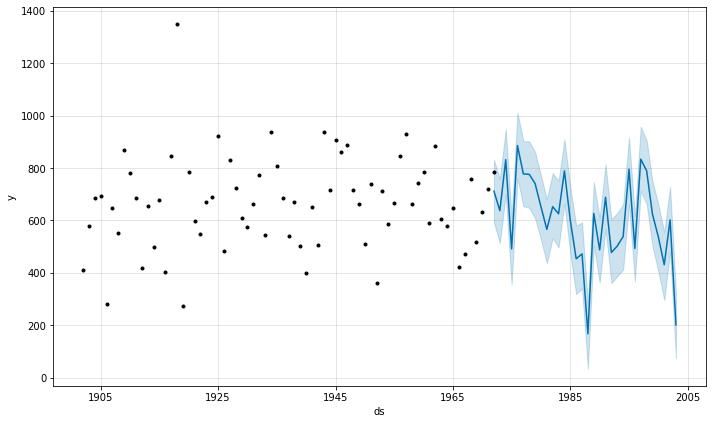

In [114]:
# forecasts with different train and test sizes
# 70% train, 30% test

training_X = fitting.loc[:70]
training_y = fitting.loc[:70].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)
testing_X = fitting.loc[70:]
testing_y = fitting.loc[70:].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')
pro_regressor.add_regressor('CC')
pro_regressor.add_regressor('VP')
pro_regressor.add_regressor('WDF')
pro_regressor.add_regressor('DTR')
pro_regressor.add_regressor('RCE')
pro_regressor.add_regressor('PE')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [115]:
display(forecast_data)

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  1971-12-31  966.424371  591.511046   831.220435   966.424371   966.424371   
1  1972-12-31  966.271258  513.896639   758.813294   966.271258   966.271258   
2  1973-12-31  966.118563  700.244075   948.181950   966.118563   966.118563   
3  1974-12-31  965.965868  355.248120   615.667146   965.965868   965.965868   
4  1975-12-31  965.813173  760.869217  1011.152238   965.813173   965.813173   
5  1976-12-31  965.660060  654.659733   902.915414   965.660060   965.660060   
6  1977-12-31  965.507365  648.177879   902.117158   965.507365   965.507365   
7  1978-12-31  965.354670  608.870523   862.375354   965.354670   965.354670   
8  1979-12-31  965.201975  526.565876   771.489179   965.201975   965.201975   
9  1980-12-31  965.048862  436.968833   681.711587   965.048862   965.048862   
10 1981-12-31  964.896167  532.820404   780.298151   964.896167   964.896167   
11 1982-12-31  964.743472  496.726831   751.387818   964.743472   964.743472   
12 1983-12-31  964.590777  664.757331   909.964755   964.590777   964.590777   
13 1984-12-31  964.437664  473.716625   728.593213   964.437664   964.437664   
14 1985-12-31  964.284969  318.828502   579.592823   964.284969   964.284969   
15 1986-12-31  964.132274  339.956419   592.520508   964.132274   964.132274   
16 1987-12-31  963.979579   34.460795   282.568191   963.979579   963.979579   
17 1988-12-31  963.826465  504.487755   747.078270   963.826465   963.826465   
18 1989-12-31  963.673770  362.030855   609.066519   963.673770   963.673770   
19 1990-12-31  963.521075  568.301767   814.932479   963.521075   963.521075   
20 1991-12-31  963.368380  360.777202   605.160712   963.368380   963.368380   
21 1992-12-31  963.215267  386.049751   628.233369   963.215267   963.215267   
22 1993-12-31  963.062572  412.834374   661.158231   963.062572   963.062572   
23 1994-12-31  962.909877  661.654303   916.908337   962.909877   962.909877   
24 1995-12-31  962.757182  367.092646   616.628165   962.757182   962.757182   
25 1996-12-31  962.604069  711.723048   958.845943   962.604069   962.604069   
26 1997-12-31  962.451374  662.927496   906.235623   962.451374   962.451374   
27 1998-12-31  962.298679  501.703251   750.485128   962.298679   962.298679   
28 1999-12-31  962.145984  404.817494   660.838839   962.145984   962.145984   
29 2000-12-31  961.992871  296.573628   555.615364   961.992871   961.992871   
30 2001-12-31  961.840176  482.001092   728.563702   961.840176   961.840176   
31 2002-12-31  961.687481   74.067135   323.998504   961.687481   961.687481   

            CC    CC_lower    CC_upper        DTR  ...           t  \
0    43.064547   43.064547   43.064547 -38.020982  ...  986.677717   
1  -147.680833 -147.680833 -147.680833  -2.238195  ...  986.066241   
2    63.293479   63.293479   63.293479 -10.964322  ...  985.456437   
3   -65.528423  -65.528423  -65.528423 -55.983204  ...  984.846632   
4    47.094346   47.094346   47.094346  -4.306400  ...  984.236827   
5   130.840808  130.840808  130.840808   0.424974  ...  983.625352   
6    88.534973   88.534973   88.534973   1.473242  ...  983.015547   
7   209.997907  209.997907  209.997907 -18.273870  ...  982.405742   
8   213.049645  213.049645  213.049645   7.139558  ...  981.795938   
9    81.744974   81.744974   81.744974  11.247638  ...  981.184462   
10   26.409299   26.409299   26.409299  -1.728226  ...  980.574658   
11   37.088031   37.088031   37.088031  22.041970  ...  979.964853   
12   33.787076   33.787076   33.787076   9.717732  ...  979.355048   
13   34.671092   34.671092   34.671092  34.932840  ...  978.743573   
14   82.271622   82.271622   82.271622  -1.218258  ...  978.133768   
15   61.506637   61.506637   61.506637   1.019937  ...  977.523963   
16   60.378106   60.378106   60.378106 -15.072401  ...  976.914159   
17   83.371940   83.371940   83.371940   8.074501  ...  976.302683   
18   93.119634   93.119634   93.119634  

In [116]:
_70_30 = pd.DataFrame()
_70_30['ds'] = forecast_data['ds']
_70_30['predict'] = forecast_data['yhat']
_70_30['actual'] = fitting['y'].iloc[:70]

# apply percent error formula

_70_30['percent_error'] = (_70_30['predict'] - _70_30['actual'])/_70_30['actual']*100

# add to compare dataframe
compare['7030_predict'] = _70_30['predict']
compare['7030_diff'] = abs(_70_30['predict'] - _70_30['actual'])
compare['7030_pct_error'] = abs(_70_30['percent_error'])

# display dataframe
_70_30.head()

ds     predict  actual  percent_error
0 1971-12-31  711.549894   412.5      72.496944
1 1972-12-31  637.701073   578.3      10.271671
2 1973-12-31  832.332839   686.1      21.313633
3 1974-12-31  491.305522   694.5     -29.257664
4 1975-12-31  886.100491   279.8     216.690669

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


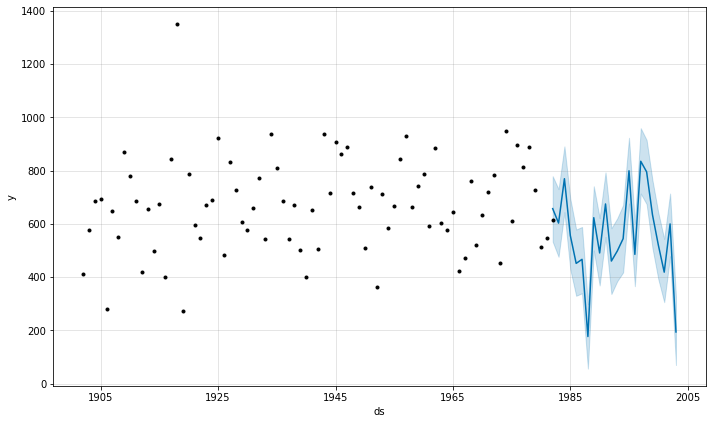

In [117]:
# forecasts with different train and test sizes
# 80% train, 20% test

training_X = fitting.loc[:80]
training_y = fitting.loc[:80].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)
testing_X = fitting.loc[80:]
testing_y = fitting.loc[80:].drop(['ds','t', 'CC', 'VP', 'WDF', 'DTR', 'RCE', 'PE'], axis=1)


# additional regressors
pro_regressor = Prophet()
pro_regressor.add_regressor('t')
pro_regressor.add_regressor('CC')
pro_regressor.add_regressor('VP')
pro_regressor.add_regressor('WDF')
pro_regressor.add_regressor('DTR')
pro_regressor.add_regressor('RCE')
pro_regressor.add_regressor('PE')

# fitting the data
pro_regressor.fit(training_X)
future_data = pro_regressor.make_future_dataframe(periods=100)

# forecast the data 
forecast_data = pro_regressor.predict(testing_X)
pro_regressor.plot(forecast_data);

In [118]:
display(forecast_data)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  1981-12-31  621.141533  533.322435  779.288123   621.141533   621.141533   
1  1982-12-31  620.969967  476.491409  730.541979   620.969967   620.969967   
2  1983-12-31  620.798400  644.134375  891.317697   620.798400   620.798400   
3  1984-12-31  620.626364  429.023164  694.918243   620.626364   620.626364   
4  1985-12-31  620.454797  330.019871  579.033816   620.454797   620.454797   
5  1986-12-31  620.283231  339.444132  588.572776   620.283231   620.283231   
6  1987-12-31  620.111664   56.594444  298.213176   620.111664   620.111664   
7  1988-12-31  619.939628  500.522443  741.563860   619.939628   619.939628   
8  1989-12-31  619.768061  368.859351  622.076479   619.768061   619.768061   
9  1990-12-31  619.596494  551.120430  793.483079   619.596494   619.596494   
10 1991-12-31  619.424928  336.746547  583.651897   619.424928   619.424928   
11 1992-12-31  619.252891  384.953570  620.925561   619.252891   619.252891   
12 1993-12-31  619.081325  418.031733  670.888502   619.081325   619.081325   
13 1994-12-31  618.909758  676.700413  923.615795   618.909758   618.909758   
14 1995-12-31  618.738192  366.095331  603.604264   618.738192   618.738192   
15 1996-12-31  618.566155  714.179892  959.659469   618.566155   618.566155   
16 1997-12-31  618.394589  674.456604  915.446352   618.394589   618.394589   
17 1998-12-31  618.223022  509.034211  763.924925   618.223022   618.223022   
18 1999-12-31  618.051456  392.239480  641.472288   618.051456   618.051456   
19 2000-12-31  617.879419  306.020709  543.753954   617.879419   617.879419   
20 2001-12-31  617.707853  478.677036  714.206264   617.707853   617.707853   
21 2002-12-31  617.536286   69.791147  325.842792   617.536286   617.536286   

            CC    CC_lower    CC_upper       DTR  ...            t  \
0    19.291106   19.291106   19.291106 -0.081682  ...  1257.469960   
1    30.479521   30.479521   30.479521  2.273436  ...  1256.790424   
2    27.021015   27.021015   27.021015  1.052368  ...  1256.110889   
3    27.947225   27.947225   27.947225  3.550645  ...  1255.429492   
4    77.819669   77.819669   77.819669 -0.031155  ...  1254.749957   
5    56.063597   56.063597   56.063597  0.190602  ...  1254.070422   
6    54.881202   54.881202   54.881202 -1.403804  ...  1253.390887   
7    78.972505   78.972505   78.972505  0.889559  ...  1252.709490   
8    89.185443   89.185443   89.185443 -0.648707  ...  1252.029955   
9    97.102564   97.102564   97.102564  2.071328  ...  1251.350420   
10   61.354816   61.354816   61.354816  0.311306  ...  1250.670885   
11   41.175271   41.175271   41.175271  0.142882  ...  1249.989488   
12   41.175271   41.175271   41.175271  0.142882  ...  1249.309953   
13   41.175271   41.175271   41.175271  0.142882  ...  1248.630417   
14   53.624907   53.624907   53.624907  0.142882  ...  1247.950882   
15    9.260454    9.260454    9.260454  0.142882  ...  1247.269485   
16  -22.585391  -22.585391  -22.585391  0.142882  ...  1246.589950   
17  -19.604769  -19.604769  -19.604769  0.142882  ...  1245.910415   
18  -32.103672  -32.103672  -32.103672  0.142882  ...  1245.230880   
19 -135.238094 -135.238094 -135.238094  0.142882  ...  1244.549483   
20   45.003276   45.003276   45.003276  0.142882  ...  1243.869948   
21  124.977532  124.977532  124.977532  0.142882  ...  1243.190413   

        t_lower      t_upper       yearly  yearly_lower  yearly_upper  \
0   1257.469960  1257.469960 -1242.410066  -1242.410066  -1242.410066   
1   1256.790424  1256.790424 -1249.716905  -1249.716905  -1249.716905   
2   1256.110889  1256.110889 -1249.345421  -1249.345421  -1249.345421   
3   1255.429492  1255.429492 -1227.435199  -1227.435199  -1227.435199   
4   1254.749957  1254.749957 -1242.410066  -1242.410066  -1242.410066   
5   1254.070422  1254.070422 -1249.716905  -1249.716905  -1249.716905   
6   1253.390887  1253.390887 -1249.345421  -1249.345421  -1249.345421  

In [119]:
_80_20 = pd.DataFrame()
_80_20['ds'] = forecast_data['ds']
_80_20['predict'] = forecast_data['yhat']
_80_20['actual'] = fitting['y'].iloc[:80]

# apply percent error formula

_80_20['percent_error'] = (_80_20['predict'] - _80_20['actual'])/_80_20['actual']*100

# add to compare dataframe
compare['8020_predict'] = _80_20['predict']
compare['8020_diff'] = abs(_80_20['predict'] - _80_20['actual'])
compare['8020_pct_error'] = abs(_80_20['percent_error'])

# display dataframe
_80_20.head()

ds     predict  actual  percent_error
0 1981-12-31  657.410770   412.5      59.372308
1 1982-12-31  603.145686   578.3       4.296332
2 1983-12-31  769.849920   686.1      12.206664
3 1984-12-31  556.649621   694.5     -19.848867
4 1985-12-31  451.755294   279.8      61.456503

In [120]:
compare.head()

ds  actual  5050_predict   5050_diff  5050_pct_error  6040_predict  \
0 1952-12-31   412.5    649.755648  237.255648       57.516521    776.216617   
1 1953-12-31   578.3    634.679403   56.379403        9.749162    595.130570   
2 1954-12-31   686.1    799.521275  113.421275       16.531304    625.194702   
3 1955-12-31   694.5    736.464621   41.964621        6.042422    680.119896   
4 1956-12-31   279.8    918.542046  638.742046      228.285220    506.794738   

    6060_diff  6040_pct_error  7030_predict   7030_diff  7030_pct_error  \
0  363.716617       88.173725    711.549894  299.049894       72.496944   
1   16.830570        2.910353    637.701073   59.401073       10.271671   
2   60.905298        8.877029    832.332839  146.232839       21.313633   
3   14.380104        2.070569    491.305522  203.194478       29.257664   
4  226.994738       81.127498    886.100491  606.300491      216.690669   

   8020_predict   8020_diff  8020_pct_error  
0    657.410770  244.910770       59.372308  
1    603.145686   24.845686        4.296332  
2    769.849920   83.749920       12.206664  
3    556.649621  137.850379       19.848867  
4    451.755294  171.955294       61.456503

In [121]:
train_test_describe = compare.describe().T
train_test_describe['range'] = train_test_describe['max'] - train_test_describe['min']
train_test_describe

count        mean         std         min         25%  \
actual           51.0  661.568627  194.231150  273.600000  542.950000   
5050_predict     51.0  654.784178  174.941071  214.274539  540.208521   
5050_diff        51.0  167.768973  165.938663    2.500402   40.270795   
5050_pct_error   51.0   28.839529   35.134244    0.300385    5.719656   
6040_predict     42.0  639.272356  165.248907  215.484308  523.462926   
6060_diff        42.0  211.039837  180.417497    6.834798   51.747906   
6040_pct_error   42.0   36.435569   38.376098    1.055730    8.320515   
7030_predict     32.0  608.319253  169.638188  167.288540  492.827782   
7030_diff        32.0  200.645773  222.718709    1.778816   68.734401   
7030_pct_error   32.0   35.322440   43.471735    0.213697   12.428406   
8020_predict     22.0  557.249606  171.142670  177.029858  471.696037   
8020_diff        22.0  187.030799  152.059078    9.909275   60.072695   
8020_pct_error   22.0   32.738953   30.574194    1.172279   10.213697   

                       50%         75%          max        range  
actual          669.900000  777.900000  1350.400000  1076.800000  
5050_predict    649.175216  800.279342   965.293987   751.019448  
5050_diff       127.800458  235.438466   869.721094   867.220692  
5050_pct_error   19.224437   40.053577   228.285220   227.984835  
6040_predict    633.385567  795.038144   909.507030   694.022722  
6060_diff       159.244416  339.309641   710.563823   703.729025  
6040_pct_error   26.931567   43.626360   192.877188   191.821458  
7030_predict    624.615499  750.038889   886.100491   718.811951  
7030_diff       138.348452  247.013401  1183.111460  1181.332643  
7030_pct_error   20.732818   41.545063   216.690669   216.476972  
8020_predict    550.649222  651.655048   835.390725   658.360867  
8020_diff       164.676179  261.536750   554.745949   544.836674  
8020_pct_error   25.936290   40.107889   131.866916   130.694637

**Different Train and Testing Sizes**
* I expected that the mean percent error for the 80/20 train/test data would be the least. However, the 50/50 train/test had the lowest mean percent error of 28.60%
* The percent errors are all pretty high, not indicative of a "good" model
* also looking at the abolsute errors in the `compare` dataframe, there is a wide range of absolute errors (this is also showin in the `test_train_describe` dataframe, showing the minimum and maximum differences for each train/ test split
    * the minimum difference (absolute value) of all train/test splits was 6.83 mm
    * the maximum difference (absolute value) of all the train/ test splits was 909.51 mm

### Metrics to Assess the Performance of the Model
Note from Dr. Silverstein about assessing the performance of the model:


In terms of performance metrics, as you experienced, the more training data you give the model, the better it will fit that set of data and the lower the error will be. First, I would look at the absolute error so that you avoid getting negative errors as those do not make sense. Regarding the large range of errors, you can plot to see where you have possible outliers and try to make sense of those data points using what you know about the dataset and data collection. You may also want to compare the mean squared error (MSE) and/or the root mean squared error (RMSE) between multiple models and recommend using the model with the lowest value. 

I'm including a few links that may help you look into other performance metrics for your time series models. 
https://www.kdnuggets.com/2018/11/sales-forecasting-using-prophet.html
https://nextjournal.com/eric-brown/forecasting-with-prophet-part-4 (you may want to start on parts 1-3, but part 4 is where the discussion on metrics begins)

To say what are "good" or "acceptable" values of these metrics can be a difficult task and some of the metrics have no actual meaning, but are only used to compare multiple models predicting the same output variable. 

***

To assess the performance of the model, will compare the MSE and RMSE between multiple models.

In [122]:
# import ML metrics--> source: https://github.com/benhamner/Metrics
# source: https://github.com/benhamner/Metrics/blob/master/Python/README.md
# pip install ml_metrics
import ml_metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [123]:
# r2 values for each model
# source: https://nextjournal.com/eric-brown/forecasting-with-prophet-part-4
r2 = []

r2_5050 = r2_score(_50_50['actual'], _50_50['predict'])
r2.append(r2_5050)
print('50/50 R2:', r2_5050)

r2_6040 = r2_score(_60_40['actual'], _60_40['predict'])
r2.append(r2_6040)
print('60/40 R2:', r2_6040)

r2_7030 = r2_score(_70_30['actual'], _70_30['predict'])
r2.append(r2_7030)
print('70/30 R2:', r2_7030)

r2_8020 = r2_score(_80_20['actual'], _80_20['predict'])
r2.append(r2_8020)
print('80/20 R2:', r2_8020)


50/50 R2: -0.4908918175168566
60/40 R2: -0.9951050103559986
70/30 R2: -1.1789495813265072
80/20 R2: -0.12811640212313824


In [124]:
# mean squared error
# source: https://nextjournal.com/eric-brown/forecasting-with-prophet-part-4
mse = []

mse_5050 = mean_squared_error(_50_50['actual'], _50_50['predict'])
mse.append(mse_5050)
print('50/50 MSE:', mse_5050)

mse_6040 = mean_squared_error(_60_40['actual'], _60_40['predict'])
mse.append(mse_6040)
print('60/40 MSE:', mse_6040)

mse_7030 = mean_squared_error(_70_30['actual'], _70_30['predict'])
mse.append(mse_7030)
print('70/30 MSE:', mse_7030)

mse_8020 = mean_squared_error(_80_20['actual'], _80_20['predict'])
mse.append(mse_8020)
print('80/20 MSE:', mse_8020)

50/50 MSE: 55142.15369778764
60/40 MSE: 76313.27474190768
70/30 MSE: 88312.23632096278
80/20 MSE: 57051.484686099335


want to minimize the mean squared error, these values are very high

In [125]:
# mean absolute error
# source: https://nextjournal.com/eric-brown/forecasting-with-prophet-part-4

mae = []

mae_5050 = mean_absolute_error(_50_50['actual'], _50_50['predict'])
mae.append(mae_5050)
print('50/50 MAE:', mae_5050)

mae_6040 = mean_absolute_error(_60_40['actual'], _60_40['predict'])
mae.append(mae_6040)
print('60/40 MAE:', mae_6040)

mae_7030 = mean_absolute_error(_70_30['actual'], _70_30['predict'])
mae.append(mae_7030)
print('70/30 MAE:', mae_7030)

mae_8020 = mean_absolute_error(_80_20['actual'], _80_20['predict'])
mae.append(mae_8020)
print('80/20 MAE:', mae_8020)

50/50 MAE: 167.7689726850525
60/40 MAE: 211.03983698369333
70/30 MAE: 200.64577272300744
80/20 MAE: 187.03079926344773


want to minimize the mean absolute error, these values are high

**Use metrics**

In [126]:
# try with metrics
# mean square error

mse_5050 = metrics.mse(_50_50['actual'], _50_50['predict'])
print('50/50 MSE:', mse_5050)

mse_6040 = metrics.mse(_60_40['actual'], _60_40['predict'])
print('60/40 MSE:', mse_6040)

mse_7030 = metrics.mse(_70_30['actual'], _70_30['predict'])
print('70/30 MSE:', mse_7030)

mse_8020 = metrics.mse(_80_20['actual'], _80_20['predict'])
print('80/20 MSE:', mse_8020)

50/50 MSE: 55142.15369778764
60/40 MSE: 76313.27474190768
70/30 MSE: 88312.23632096278
80/20 MSE: 57051.484686099335


want to minimize MSE --> these values are very high

In [127]:
# Absolute error
ae_5050 = metrics.ae(_50_50['actual'], _50_50['predict'])
print('50/50 absolute error:', ae_5050)

ae_6040 = metrics.ae(_60_40['actual'], _60_40['predict'])
print('\n60/40 absolute:', ae_6040)

ae_7030 = metrics.ae(_70_30['actual'], _70_30['predict'])
print('\n30/30 absolute:', ae_7030)

ae_8020 = metrics.ae(_80_20['actual'], _80_20['predict'])
print('\n30/30 absolute:', ae_8020)

50/50 MSE: [237.25564768  56.37940332 113.42127472  41.96462127 638.74204567
  21.05932709 190.18827355  95.09398703 192.36101316  18.61566705
 145.99960815  46.05448934 127.80045762 227.06893778 279.72362967
  33.65808407 869.72109371 160.00900777 178.25308722 233.62128521
  80.71129931 237.29542192  30.57481186   3.16538675 317.33740869
   2.50040212 114.66170485  84.54400973  24.13982515  28.81319649
 194.64723891 240.17488739 453.8723135  344.12648951 198.04165712
 309.29299285  21.32478377  10.59048229 277.19423756 167.46921588
  17.66710719 366.03081972 137.76231736 378.34313367  19.628507
  82.77086193  38.5769684  100.24743571  97.55329264 121.54299553
 148.62546104]

60/40 MSE: [363.71661705  16.83056963  60.9052978   14.38010355 226.99473817
   6.8347979  297.9388136  383.02210126 331.86116639 195.78162381
 340.37536308  23.54645942 374.24815764 124.71958124 507.70702992
  41.46232536 537.94546542 527.7119858   98.60396345  25.28203282
 129.15663789  36.99316821 117.76170304 

In [129]:
# root mean square error
rmse = []

rmse_5050 = metrics.rmse(_50_50['actual'], _50_50['predict'])
rmse.append(rmse_5050)
print(rmse_5050)

rmse_6040 = metrics.rmse(_60_40['actual'], _60_40['predict'])
rmse.append(rmse_6040)
print(rmse_6040)

rmse_7030 = metrics.rmse(_70_30['actual'], _70_30['predict'])
rmse.append(rmse_7030)
print(rmse_7030)

rmse_8020 = metrics.rmse(_80_20['actual'], _80_20['predict'])
rmse.append(rmse_8020)
print(rmse_8020)

234.82366511445912
276.24857418981856
297.1737476981484
238.85452619973384


In [133]:
# create dataframe to compare the metrics that were found

metrics = pd.DataFrame()
metrics['Split'] = ['50/50', '60/40', '70/30', '80/20']
metrics['R2'] = r2
metrics['MAE'] = mae
metrics['MSE'] = mse
metrics['RMSE'] = rmse

# display dataframe
print('Summary of Metrics:')
metrics.head()

Summary of Metrics:


Split        R2         MAE           MSE        RMSE
0  50/50 -0.490892  167.768973  55142.153698  234.823665
1  60/40 -0.995105  211.039837  76313.274742  276.248574
2  70/30 -1.178950  200.645773  88312.236321  297.173748
3  80/20 -0.128116  187.030799  57051.484686  238.854526